In [1]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import squarify
from pyvis.network import Network
from networkx.algorithms import community
import community as community_louvain
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['image.cmap'] = 'icefire'
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams["font.family"] = "monospace";

![](https://upload.wikimedia.org/wikipedia/commons/2/2e/Game_of_Thrones_2011_logo.svg)

# Introduction
"Game of Thrones," the critically acclaimed HBO series based on George R.R. Martin's epic fantasy novels, has captivated audiences worldwide with its intricate plotlines, complex characters, and stunning visuals. Set in the fictional continents of Westeros and Essos, the series weaves together the destinies of noble families as they vie for power and control over the Iron Throne. With themes of betrayal, loyalty, and ambition, "Game of Thrones" presents a world where alliances shift like the changing seasons, and the struggle for survival is a constant battle.

The series is renowned for its richly developed characters and their intricate relationships. From the Stark family in the icy North to the Lannisters in the opulent capital of King's Landing, each character's journey is shaped by a web of alliances and rivalries. These connections form the backbone of the narrative, driving the story forward with unexpected twists and turns. With its epic scale and intricate storytelling, "Game of Thrones" offers a fertile ground for analyzing the dynamics of relationships and power.

Social network analysis (SNA) is a powerful tool that allows us to explore and visualize the relationships between characters in "Game of Thrones." By representing characters as nodes and their interactions as edges, we can uncover hidden patterns and insights within the complex web of connections. SNA enables us to quantify the importance of each character, identify key influencers, and analyze the flow of information and power throughout the series.

In this notebook, we will delve into the intricate relationships of "Game of Thrones" using social network analysis techniques. We'll examine how alliances are formed and dissolved, identify central figures who wield significant influence, and explore how the series' narrative structure is reflected in the network of interactions. By applying SNA to "Game of Thrones," we aim to gain a deeper understanding of the dynamics that drive the story and reveal the underlying forces at play in this epic saga.

Whether you're a fan of the series or a data enthusiast, this analysis offers a unique lens through which to explore the captivating world of Westeros. Join us as we embark on a journey through the tangled web of relationships that define "Game of Thrones" and uncover the hidden connections that shape its narrative.

If you aren´t familiar with network science, then be sure to read [Fundamentals of Social Network Analysis (SNA)](https://www.kaggle.com/code/mexwell/fundamentals-of-social-network-analysis-sna) before digging into this notebook. There I will give a quick overview over the most important parts related to SNA. 

<div class="alert alert-danger">
  <strong>Note!</strong> This notebook provides a detailed description of the characters and their relevance throughout the series. I would like to point out that there is a risk of spoilers. 
</div>

# Definitions
If you are too lazy to read the previous notebook carefully, I have copied a summary of the most important terms here. 

## Centrality
>Not all nodes are equally important. Some nodes play an outsized role in the network, e.g. if they have many connections. Centrality measures the importance or influence of a node within a network. 
- Degree Centrality: Do you have many connections?
- Weighted Degree Centrality: Do you have many interactions?
- Betweenness Centrality: Do you help to connect different parts of the network?
- Closeness Centrality: How quickly can you reach all other nodes in the network?
- Eigenvector Centrality: Do you have many connections to important people?
- PageRank: Do you have many interactions with important people?

For some the difference between Eigenvector Centrality and PageRank is not completely clear. So let´s quickly do some examples. The Eigenvector centrality measures how connected a character is, not just directly, but through their connections to other important characters. A character with high eigenvector centrality is important because they are connected to other characters who are themselves important. 

**Example:** Think of a central character who is frequently interacting with other main characters. Even if this character doesn’t have the most connections, their connections to other important characters make them highly influential in the story.

PageRank also considers the importance of connected characters but introduces the idea that a character can be important even if they are less connected, as long as they are linked to by other important characters. PageRank also accounts for "random jumps," meaning even less central characters can gain importance if there’s a probability of connections being formed to them randomly.

**Example:** A minor character might have fewer connections but if those connections are with very important characters, or if they have unique connections no one else has, their PageRank can be surprisingly high.

## Community
>Communities in networks are subsets of nodes that are more densely connected internally than with the rest of the network. This concept stems from the observation that in many real-world networks, such as social, biological, and technological networks, nodes tend to form tightly-knit groups with strong internal connections. These groups often represent functional or logical units within the network.

# Data
The linked data set contains both the data of the books and the series. In this notebook, however, I will only focus on the relationships in the movies. 

In fact, these deviate from the book very significantly in some cases, and it would probably be very relevant to analyze this deviation as well. However, I think this would only make the notebook unnecessarily complex and is perhaps work for a separate notebook.

For the series the networks where created by parsing fan-generated scripts from https://genius.com/artists/Game-of-thrones. Pairs of characters are connected by (undirected) edges weighted by the number of interactions. 

There are five interaction types. Character A and Character B are connected whenever:

- Character A speaks directly after Character B
- Character A speaks about Character B
- Character C speaks about Character A and Character B
- Character A and Character B are mentioned in the same stage direction
- Character A and Character B appear in a scene together

The networks are separated by season. In total we have 16 CSV files (2 files per season - edges and notes, for 8 seasons)

# Helper Function
In this section I put all helper function I need for the preprocessing and visualization. 

In [4]:
def calculate_centralities(G, dataframe):
    degree_centrality = nx.degree_centrality(G)
    weighted_degree = {node: sum(data['Weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}
    betweenness_centrality = nx.betweenness_centrality(G, weight='Weight', normalized=True)
    closeness_centrality = nx.closeness_centrality(G, distance='Weight')
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=10000, tol=1e-08)
    pagerank = nx.pagerank(G, weight='Weight')

    centralities_df = pd.DataFrame({
        'Character': list(G.nodes()),
        'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
        'Weighted Degree': [weighted_degree[node] for node in G.nodes()],
        'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
        'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
        'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
        'PageRank': [pagerank[node] for node in G.nodes()],
    })
    centralities_df['Centrality Mean'] = centralities_df.iloc[:, 1:].mean(axis=1)
    return centralities_df

In [5]:
def plot_network(G):
    partition = community_louvain.best_partition(G.to_undirected(), weight='Weight')
    centrality = nx.pagerank(G, weight='Weight')

    node_sizes = {node: centrality[node] * 250 for node in G.nodes()}
    title_sizes = {node: centrality[node] * 50 for node in G.nodes()}

    distinct_colors = [
        "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231", 
        "#911eb4", "#46f0f0", "#f032e6", "#bcf60c", "#fabebe", 
        "#008080", "#e6beff", "#ff7f0e", "#7fbf7f", "#b1c0c0", 
        "#ff0000", "#0000ff", "#00ff00", "#ffff00", "#00ffff"
    ]
    sorted_communities = sorted(set(partition.values()))
    community_colors = {community_id: distinct_colors[i % len(distinct_colors)]
                        for i, community_id in enumerate(sorted_communities)}

    net = Network(notebook=True, height='800px', width='100%', bgcolor='#ffffff', font_color='black', cdn_resources='in_line')
    net.repulsion()

    pos = nx.spring_layout(G, seed=42)

    for node in G.nodes():
        community_id = partition[node]
        x, y = pos[node]
        net.add_node(node,
                     x=x*1500,
                     y=y*1500,
                     title=f"{node}: PageRank {centrality[node]:.4f}",
                     size=node_sizes[node],
                     label=str(node),
                     labelHighlightBold=True,
                     color=community_colors[community_id],
                     font={'size': title_sizes[node]}
                    )

    for source, target, weight in G.edges(data=True):
        net.add_edge(source, target, value=weight['Weight'], title=f"Weight: {weight['Weight']}")

    return net

In [6]:
def plot_centrality_barcharts(df, labels, title):
    num_plots = len(labels)
    nrows, ncols = 1, 6
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 8), sharey=True)
    colors = ['#D62728', '#1F77B4', '#2CA02C', '#FF7F0E', '#9467BD', '#8C564B']
    axes = axes.flatten()
    for i, label in enumerate(labels):
        ax = axes[i]
        df['rank'] = df[label].rank(ascending=False, method='min').astype(int)
        sns.barplot(
            y=df['Character'],
            x=df[label],
            ax=ax,
            order=df['Character'],
            color=colors[i % len(colors)]
        )
        for j, (index, row) in enumerate(df.iterrows()):
            ax.text(row[label] / 2, j, str(row['rank']), color='black', va='center', ha='center', fontweight='bold', size=16)
        ax.set_xlabel(label)
        ax.set_title(label)
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    plt.suptitle(title, size=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

In [7]:
def load_network(csv_pth):
    data = pd.read_csv(csv_pth)
    G = nx.from_pandas_edgelist(data, 'Source', 'Target', edge_attr='Weight')
    network = plot_network(G)
    num_edges = G.number_of_edges()
    num_nodes = G.number_of_nodes()
    return G, network, data, num_edges, num_nodes

In [8]:
def plot_protagonist_ratings(data, title):
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=data,
                   x='Eigenvector Centrality',
                   y='PageRank',
                   hue='Weighted Degree',
                   size='Weighted Degree',
                   sizes=(200, 2000),
                   palette='icefire',
                   legend=False 
                   )

    for i in range(data.shape[0]):
        plt.text(x=data['Eigenvector Centrality'].iloc[i], 
                 y=data['PageRank'].iloc[i], 
                 s=data['Character'].iloc[i],
                 fontdict=dict(color='black', size=10),
                 )

    norm = plt.Normalize(data['Weighted Degree'].min(), data['Weighted Degree'].max())
    sm = plt.cm.ScalarMappable(cmap="icefire", norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    plt.title(title)
    cbar.set_label('Weighted Degree')
    plt.show()

In [9]:
def centrality_measures(G, data, k, labels, title):
    centralities = calculate_centralities(G, data)
    top_k = centralities.sort_values(by='Centrality Mean', ascending=False).head(k).reset_index(drop=True)
    display(top_k.style.background_gradient(cmap=plt.get_cmap()))
    print('')
    print('')
    print('')
    plot_centrality_barcharts(top_k, labels, title)
    return top_k

In [10]:
labels = ['Degree Centrality', 'Weighted Degree', 
          'Betweenness Centrality', 'Closeness Centrality',
         'Eigenvector Centrality', 'PageRank']
k = 10

# Season 1

In [11]:
G1, s1_network, s1_data, num_edges, num_nodes = load_network('/kaggle/input/got-social-network/series/got-s1-edges.csv')
print(f'Number of Nodes: {num_nodes} - Number of Edges: {num_edges}')
s1_network.show('s1_network.html')

Number of Nodes: 126 - Number of Edges: 549
s1_network.html


## Communities

The network divides into five main communities.
- **The Starks:** (Robb and Bran)
- **The Lannisterws:** (Tyrion)
- **The Nights Watch:** (Jon, Sam, Pyp)
- **Kings Landing:** (Ned, Robert)
- **The Dothraiki:** (Daenerys, Drogo, Jorah)

In Season 1 of Game of Thrones, each community plays a vital role in shaping the unfolding drama. The Starks of Winterfell, particularly Robb and Bran, face significant challenges after their father, Ned, leaves for King's Landing. Robb is thrust into a leadership role as tensions rise with the Lannisters, while Bran experiences strange visions after surviving a fall that leaves him paralyzed.

The Lannisters, primarily through Tyrion, navigate the complexities of power and family loyalty. Tyrion, often underestimated by his family, uses his wit to survive the dangerous political landscape, even as he grapples with his outsider status within House Lannister.

The Night's Watch, where Jon Snow, Samwell Tarly, and Pyp serve, is depicted as a harsh and unforgiving place. Jon struggles with his new life at the Wall, trying to reconcile his noble upbringing with the reality of serving alongside criminals and outcasts. Sam and Pyp, like Jon, must adapt to the harsh conditions and find their place within the brotherhood.

In King's Landing, Ned and King Robert Baratheon grapple with the complexities of ruling a kingdom steeped in corruption. Ned’s sense of honor clashes with the deceit and intrigue of the court, while Robert struggles with the burdens of kingship, preferring to drink and hunt rather than govern.

The Dothraki, led by Khal Drogo and guided by Daenerys Targaryen and Ser Jorah Mormont, represent a vastly different culture. Daenerys’s journey from a meek, exiled princess to the powerful Khaleesi of the Dothraki is central to the season. Under Drogo’s leadership, the Dothraki are a fierce and nomadic warrior tribe, but Daenerys begins to assert her own influence, setting the stage for her future ambitions.

## Centraliy Measures

I create a new centrality which is the mean of the others. Let´s check the top 10 characters based on the mean centrality. 

,Character,Degree Centrality,Weighted Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank,Centrality Mean
0,NED,0.456000,1290,0.205509,0.165782,0.315083,0.081973,215.204058
1,TYRION,0.328000,709,0.099051,0.138581,0.229760,0.049445,118.307473
2,CATELYN,0.288000,584,0.071880,0.152625,0.236865,0.039321,97.464782
3,ROBERT,0.288000,563,0.079635,0.143021,0.248190,0.034416,93.965544
4,JON,0.208000,535,0.029784,0.142207,0.168276,0.038857,89.264521
5,DAENERYS,0.144000,535,0.035659,0.141403,0.073713,0.036366,89.238524
6,CERSEI,0.232000,444,0.070366,0.152999,0.239263,0.025593,74.120037
7,ROBB,0.240000,424,0.068237,0.145688,0.207116,0.029025,70.781678
8,SANSA,0.208000,422,0.042785,0.152439,0.202643,0.024782,70.438441
9,LITTLEFINGER,0.208000,383,0.027003,0.132275,0.204721,0.022474,63.932412


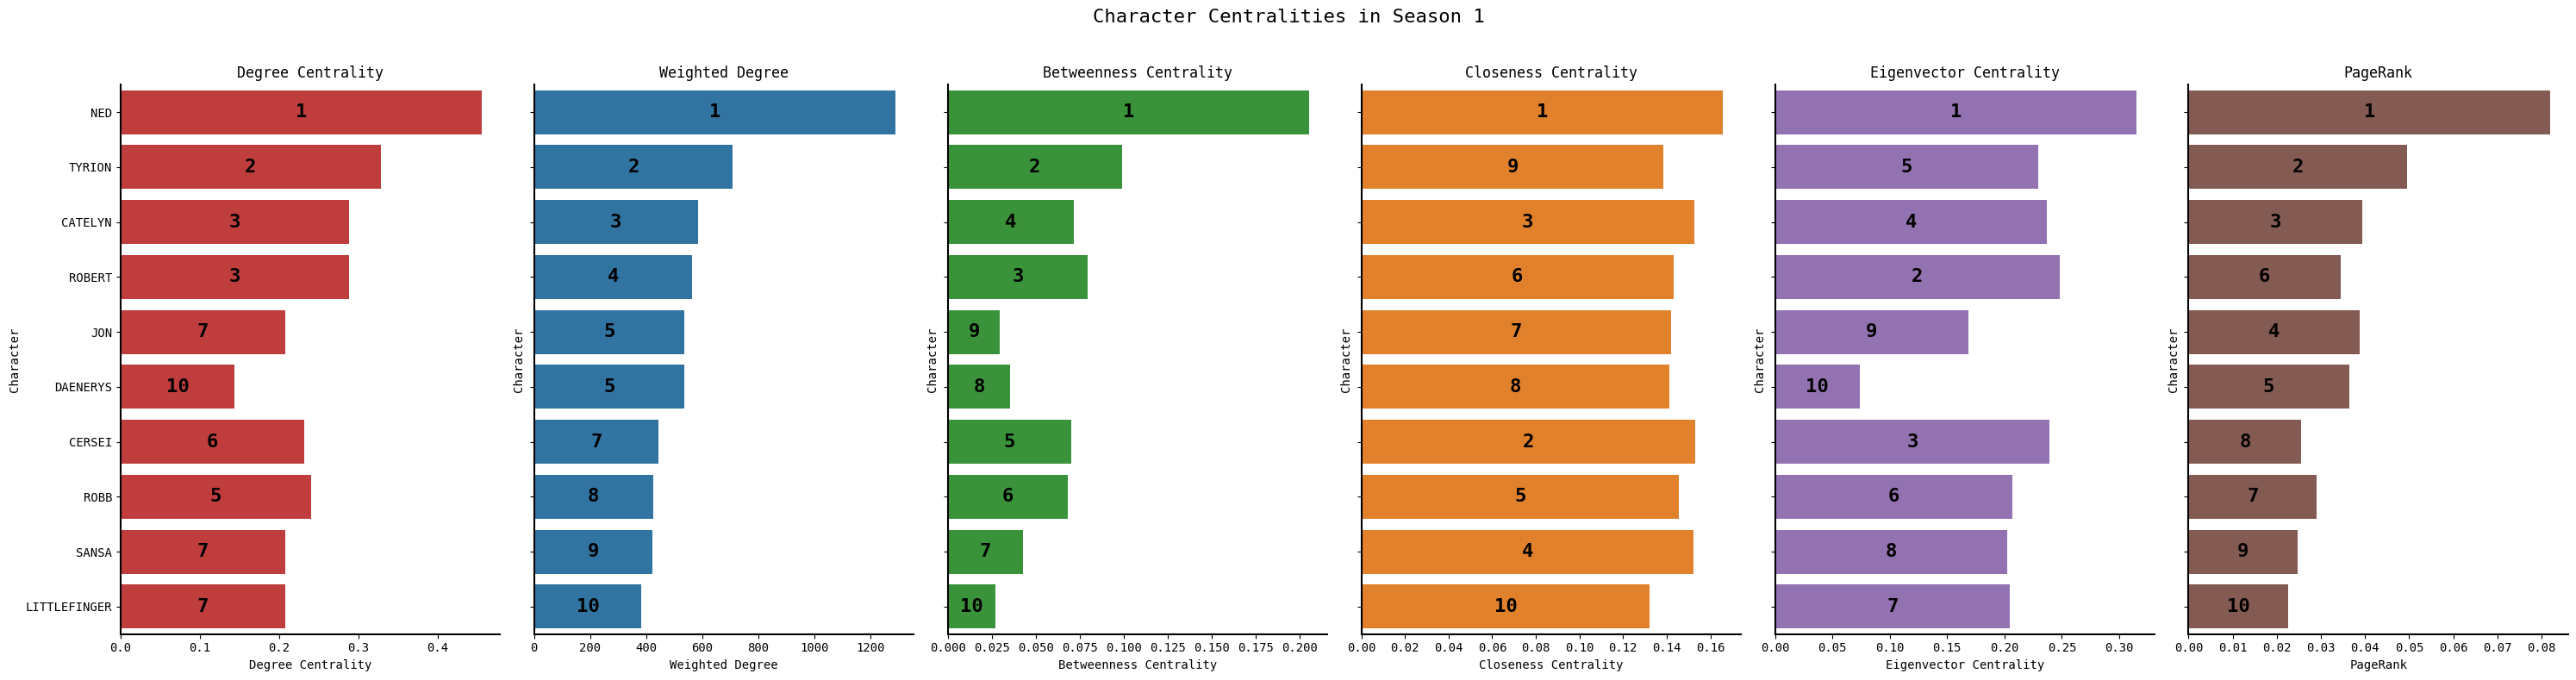

In [12]:
s1_top = centrality_measures(G1, s1_data, 10, labels=labels, title='Character Centralities in Season 1')

## Main Character

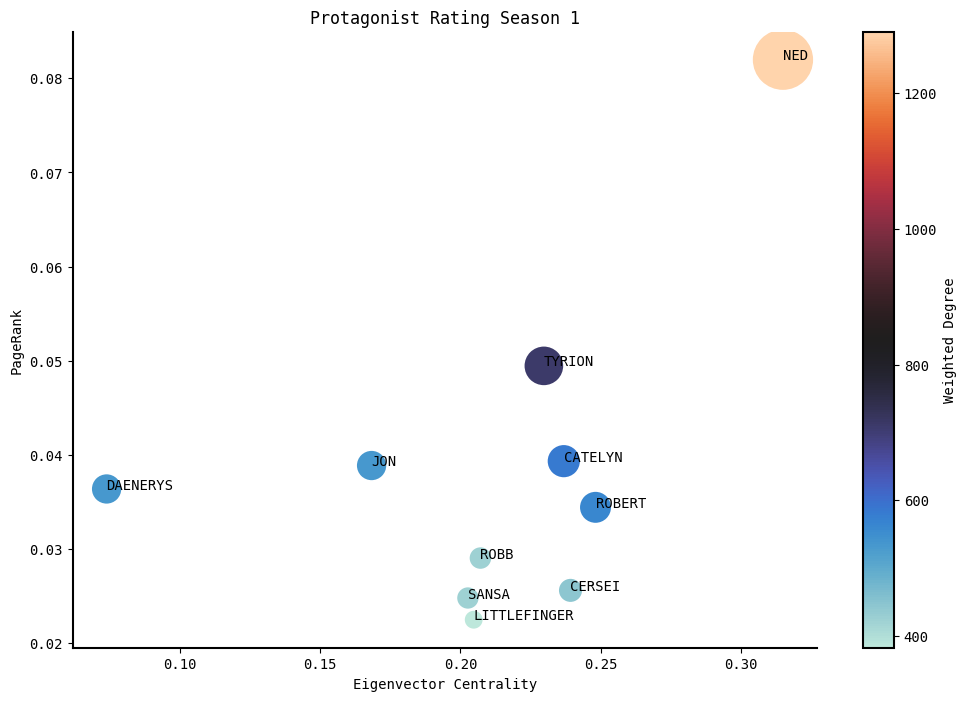

In [13]:
plot_protagonist_ratings(s1_top, 'Protagonist Rating Season 1')

In Season 1, Eddard "Ned" Stark is the most important character, as his actions and decisions set the stage for the entire series. As the head of House Stark, Ned is called to King's Landing by his old friend, King Robert Baratheon, to serve as the Hand of the King. In King's Landing, Ned quickly realizes the dangerous web of political intrigue that surrounds the Iron Throne. His investigation into the death of the previous Hand, Jon Arryn, leads him to the shocking discovery that Robert’s children are actually the offspring of Queen Cersei Lannister and her brother, Jaime.

Ned's decision to confront Cersei with this information and to try to protect Robert's line by ensuring the throne goes to its rightful heir sets off a chain of events that leads to his downfall. Despite his honorable intentions, Ned is outmaneuvered by the Lannisters, particularly by Cersei and her father, Tywin. After Robert's death, Ned attempts to install Stannis Baratheon as the rightful king, but he is betrayed by Littlefinger and arrested for treason.

The season culminates in Ned's execution, ordered by the newly crowned King Joffrey, despite promises that his life would be spared if he confessed to treason. Ned's death is a pivotal moment, shocking both the characters within the show and the audience, and it marks the beginning of the War of the Five Kings. His execution shatters the Stark family and sets his son Robb on a path of rebellion against the Lannisters, while his daughters Arya and Sansa face their own harrowing journeys.

Ned's story in Season 1 is crucial because it introduces the series' themes of honor, betrayal, and the brutal consequences of political naiveté. His death also serves as the catalyst for much of the conflict that follows, making him the most important character in the inaugural season.

> Ned Stark's Tenure As The Hand Of The King Was Short But Memorable

![](https://static1.cbrimages.com/wordpress/wp-content/uploads/2022/06/Ned-Stark-Game-of-Thrones.jpg?q=50&fit=crop&w=750&dpr=1.5)

*Source:* [cbr.com](https://www.cbr.com/who-is-game-of-thrones-main-character-of-each-season/)

# Season 2

In [14]:
G2, s2_network, s2_data, num_edges, num_nodes = load_network('/kaggle/input/got-social-network/series/got-s2-edges.csv')
print(f'Number of Nodes: {num_nodes} - Number of Edges: {num_edges}')
s2_network.show('s2_network.html')

Number of Nodes: 129 - Number of Edges: 486
s2_network.html


## Communities

The communities in season 2 are a bit looser compared to season 1. 

- **The Riverlands:** (Robb, Catelyn and Jaime)
- **Dragonstone:** (Stannis, Davos)
- **Kings Landing:** (Tyrion, Joffrey, Sansa and Cersei)
- **The North:** (Jon, Ygritte)
- **Harenhall:** (Arya, Tywin, Gendry)
- **Red Waste and Qarth:** (Daenerys, Jorah)
- **Winterfell and Iron Islands:** (Bran, Theon)

In Season 2 of Game of Thrones, each community experiences crucial developments that drive the broader narrative. In the Riverlands, Robb Stark leads the Stark forces in rebellion against the Lannisters, with his mother, Catelyn, by his side. They capture Jaime Lannister, who becomes a valuable prisoner. However, Robb’s focus on the war strains his relationships and sets the stage for future complications.

On Dragonstone, Stannis Baratheon, guided by the loyal Davos Seaworth and the enigmatic Melisandre, declares his claim to the Iron Throne. He gathers an army and prepares to challenge his rivals, believing himself the rightful heir after learning of Joffrey's illegitimacy.

In King's Landing, Tyrion Lannister assumes the role of Hand of the King, working to manage the volatile Joffrey and the political machinations of his sister, Cersei. Tyrion’s cleverness helps him navigate the treacherous court, culminating in his leadership during the Battle of Blackwater, where he plays a crucial role in defending the city from Stannis’s forces. Meanwhile, Sansa Stark remains trapped under the Lannisters' control, enduring Joffrey’s cruelty.

In the North, Jon Snow ventures beyond the Wall, where he encounters the Wildlings, including Ygritte, who challenges his loyalties and introduces him to a different way of life. Jon’s experiences with the Wildlings begin to shift his understanding of the world and his place in it.

At Harrenhal, Arya Stark becomes a servant to Tywin Lannister, where she hides her identity while gathering information and forming alliances. Her time at Harrenhal shapes her future path, as she witnesses the horrors of war and begins to embrace a darker side of herself.

In the Red Waste and later in Qarth, Daenerys Targaryen struggles to keep her small khalasar together after Khal Drogo’s death. She eventually reaches the wealthy city of Qarth, where she seeks allies and resources to continue her quest for the Iron Throne. However, she faces betrayal and treachery, testing her resolve and leadership.

Meanwhile, in Winterfell and the Iron Islands, Theon Greyjoy betrays the Starks and seizes Winterfell, seeking to prove his worth to his father, Balon Greyjoy. Bran Stark, left vulnerable in Winterfell, must flee after Theon’s betrayal, marking the beginning of his journey toward a larger destiny.

## Centraliy Measures

,Character,Degree Centrality,Weighted Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank,Centrality Mean
0,TYRION,0.257812,960,0.160091,0.118750,0.277325,0.058412,160.145398
1,CERSEI,0.242188,549,0.053812,0.110721,0.282982,0.033492,91.620532
2,ARYA,0.210938,481,0.100811,0.112438,0.166749,0.042243,80.272196
3,THEON,0.156250,447,0.066707,0.119168,0.087311,0.034267,74.577284
4,JOFFREY,0.281250,425,0.087137,0.122180,0.313308,0.027271,70.971857
5,ROBB,0.218750,420,0.073842,0.112313,0.207769,0.031976,70.107442
6,DAENERYS,0.101562,383,0.004167,0.015907,0.000000,0.035813,63.859575
7,STANNIS,0.171875,334,0.015042,0.108127,0.222284,0.020938,55.756378
8,SANSA,0.148438,325,0.022094,0.109527,0.198364,0.019264,54.249614
9,CATELYN,0.179688,323,0.058019,0.113570,0.192043,0.021627,53.927491


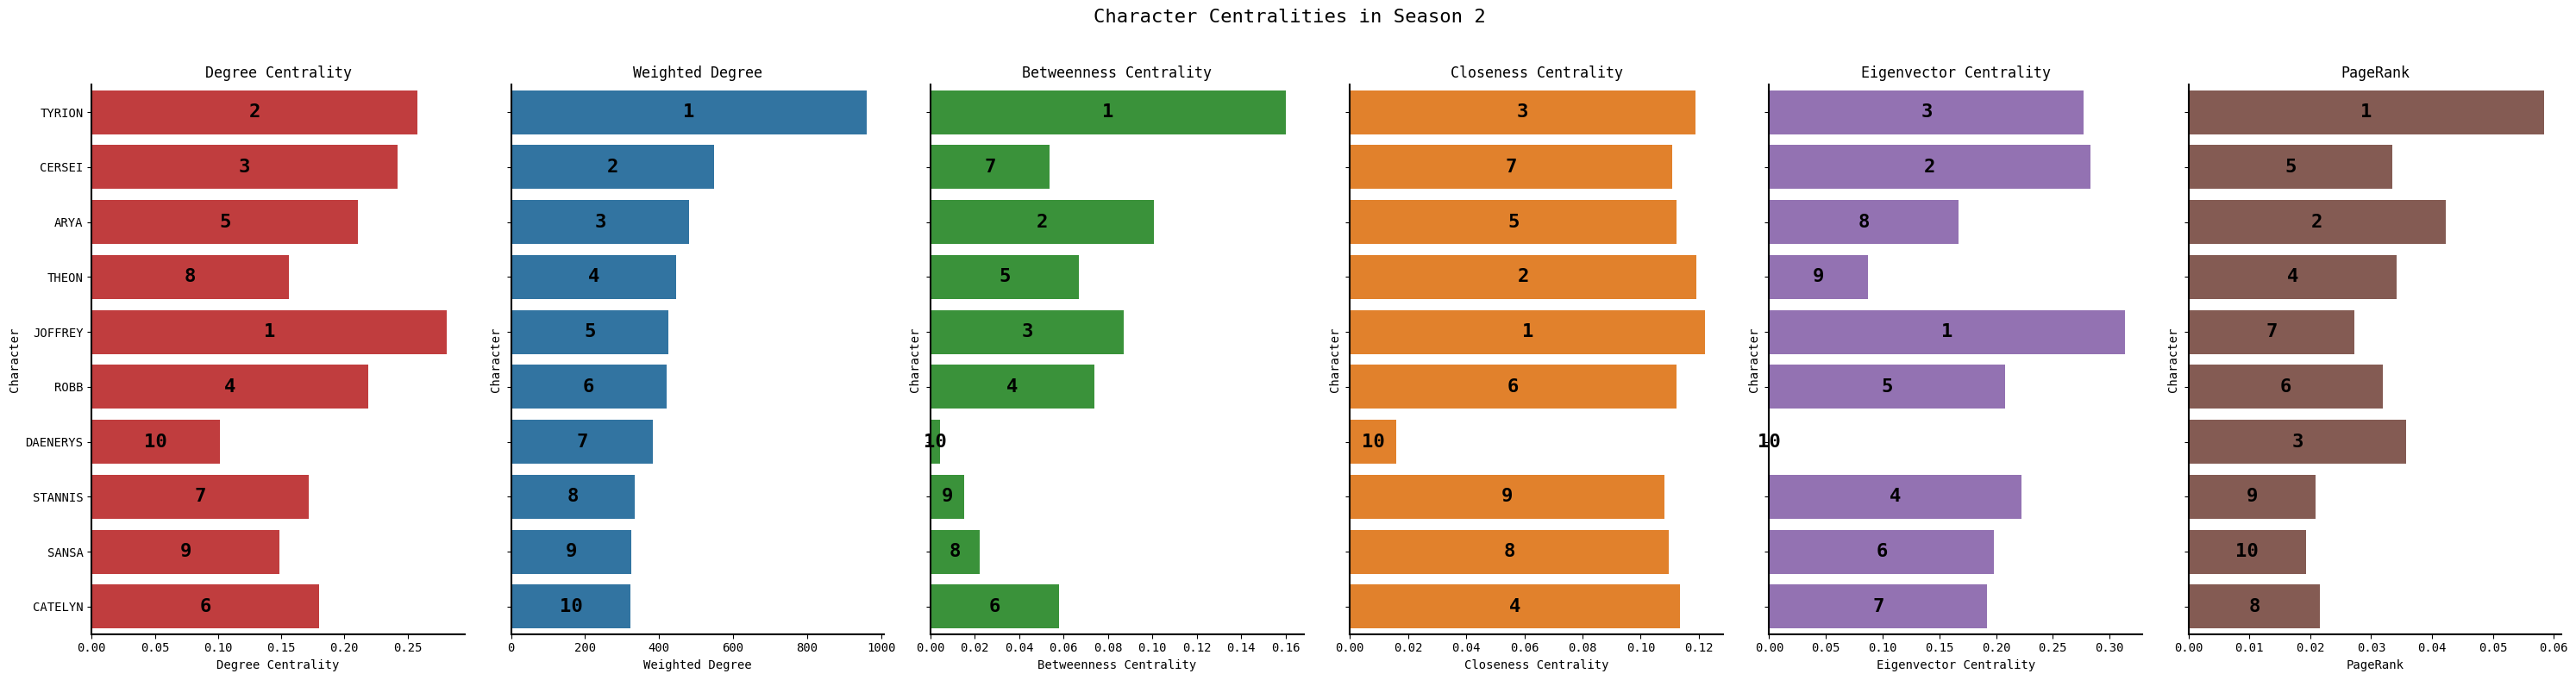

In [15]:
s2_top = centrality_measures(G2, s2_data, 10, labels=labels, title='Character Centralities in Season 2')

## Main Character

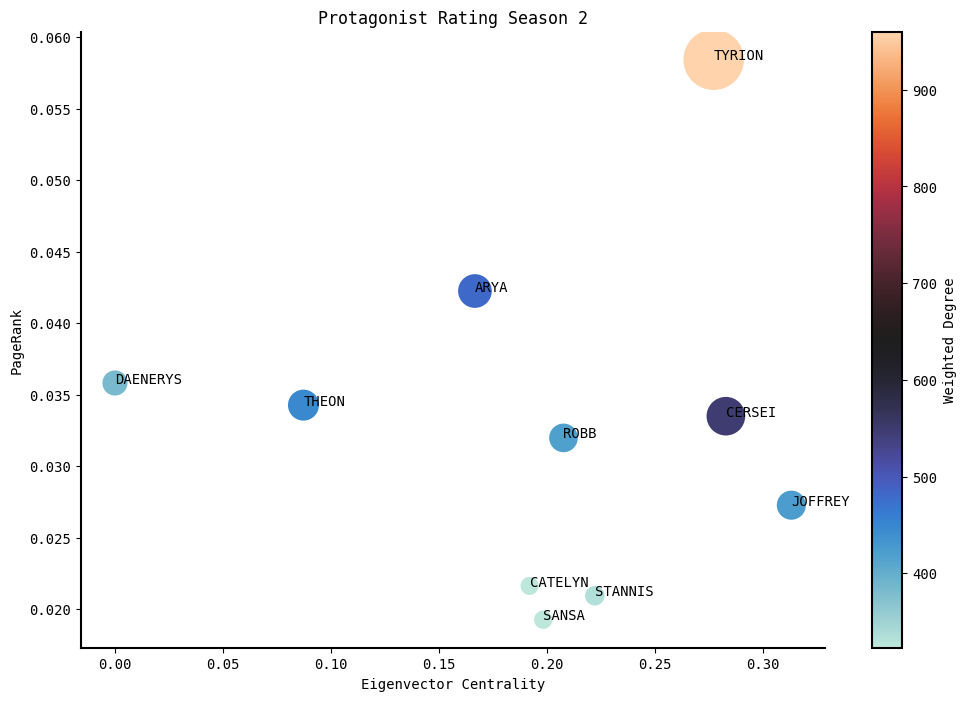

In [16]:
plot_protagonist_ratings(s2_top, 'Protagonist Rating Season 2')

In Season 2, Tyrion Lannister emerges as the most important character. As Hand of the King, Tyrion is at the center of the political turmoil in King's Landing. His sharp intellect and strategic thinking allow him to navigate the dangerous court, manage the volatile King Joffrey, and prepare the city for Stannis Baratheon’s imminent attack. The Battle of Blackwater is a pivotal moment in the season, where Tyrion’s leadership and use of wildfire are crucial in securing a victory for the Lannisters. His actions not only save the city but also solidify his position as a key player in the ongoing power struggle. Despite his successes, Tyrion faces constant threats from those around him, particularly from his sister, Cersei, and his father, Tywin, which highlights the precariousness of his position. Tyrion’s role in Season 2 is central to the survival of King’s Landing and the continuation of the Lannister rule, making him the most important character of the season.

>Tyrion Takes Charge And Leads The Defense Of King's Landing

![](https://static1.cbrimages.com/wordpress/wp-content/uploads/2021/07/Game-of-Thrones-----Tyrion-in-Blackwater-Bay.jpg?q=50&fit=crop&w=750&dpr=1.5)

*Source:* [cbr.com](https://www.cbr.com/who-is-game-of-thrones-main-character-of-each-season/)

# Season 3

In [17]:
G3, s3_network, s3_data, num_edges, num_nodes = load_network('/kaggle/input/got-social-network/series/got-s3-edges.csv')
print(f'Number of Nodes: {num_nodes} - Number of Edges: {num_edges}')
s3_network.show('s3_network.html')

Number of Nodes: 124 - Number of Edges: 504
s3_network.html


## Communities

In season 3 we have the following communities:

- **The Stark Bannermen:** (Robb, Catelyn, Walder)
- **Dreadfort:** (Theon, Ramsay)
- **Beyond the Wall/Crasters Keep:** (Jon, Ygritte)
- **The North:** (Sam, Gilly)
- **Kings Landing:** (Tyrion, Tywin)
- **Across the narrow Sea:** (Daenerys, Jorah, Barristan)
- **The Brotherhood without Banners and Dragonstone:** (Arya, Davon, Stannis)
- **The Kingslayer’s Trek:** (Jaime)

In Season 3 of Game of Thrones, the various communities continue to shape the intricate and deadly game of power in Westeros and beyond.

Among the Stark bannermen, Robb Stark faces increasing challenges as his war effort begins to falter. His marriage to Talisa Maegyr strains his alliance with House Frey, leading to a catastrophic betrayal at the Red Wedding, where Walder Frey and Roose Bolton conspire to murder Robb, his mother Catelyn, and many of their loyal followers. This event effectively ends the Stark rebellion and shifts the power balance in favor of the Lannisters.

At the Dreadfort, Theon Greyjoy is brutally tortured and psychologically broken by Ramsay Snow, later revealed to be Ramsay Bolton. Theon's identity is shattered, and he is forced to take on the name "Reek" as Ramsay asserts his dominance, highlighting the sadistic nature of the Boltons.

Beyond the Wall and at Craster's Keep, Jon Snow continues his infiltration of the Wildlings and deepens his relationship with Ygritte. However, Jon’s loyalty to the Night’s Watch conflicts with his feelings for Ygritte, leading to a tense and dangerous situation as he ultimately betrays the Wildlings to return to his brothers at the Wall.

In the North, Samwell Tarly and Gilly, now traveling together, face numerous threats as they journey back to the Wall. Sam's bravery is tested when he kills a White Walker with a dragonglass dagger, a crucial discovery that underscores the growing threat beyond the Wall.

In King’s Landing, the Lannisters consolidate their power with Tywin Lannister firmly in control. Tyrion Lannister grapples with his new role as Master of Coin and the complexities of his forced marriage to Sansa Stark. Tywin’s machinations are central to maintaining the Lannister grip on the throne, as he arranges key marriages and alliances to secure their position.

Across the Narrow Sea, Daenerys Targaryen's power grows significantly as she gains the loyalty of the Unsullied, a formidable slave army, after sacking the city of Astapor. Her strategic brilliance and growing reputation as a liberator make her a force to be reckoned with, as she continues her quest to reclaim the Iron Throne.

The Brotherhood Without Banners, led by Beric Dondarrion, takes Arya Stark under their wing, though she is eventually captured by the Hound. Arya’s journey with the Brotherhood exposes her to new ideas of justice and survival, but she remains focused on her desire for vengeance. Meanwhile, at Dragonstone, Stannis Baratheon, with the counsel of Davos Seaworth and Melisandre, struggles to rally support for his claim to the throne, relying heavily on the powers of the Lord of Light.

The Kingslayer's trek follows Jaime Lannister as he is captured and taken on a perilous journey by Brienne of Tarth. Jaime's character undergoes significant development as he loses his sword hand, a critical moment that humbles him and deepens his bond with Brienne, revealing a more complex and honorable side to the infamous Kingslayer.

## Centraliy Measures

,Character,Degree Centrality,Weighted Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank,Centrality Mean
0,TYRION,0.203252,653,0.083875,0.137892,0.269015,0.039982,108.955669
1,ROBB,0.252033,375,0.221452,0.150920,0.250801,0.029300,62.650751
2,TYWIN,0.235772,366,0.200353,0.148910,0.294864,0.023212,61.150519
3,SANSA,0.154472,363,0.023247,0.125510,0.237025,0.021917,60.593695
4,CERSEI,0.162602,354,0.015983,0.124873,0.234267,0.021276,59.093167
5,JAIME,0.138211,335,0.055060,0.136971,0.170879,0.023321,55.920740
6,JON,0.154472,323,0.210009,0.138514,0.056145,0.022414,53.930259
7,DAENERYS,0.097561,294,0.036842,0.107706,0.008120,0.024722,49.045825
8,BRAN,0.138211,292,0.049495,0.116367,0.074458,0.020998,48.733255
9,ARYA,0.130081,288,0.063764,0.139456,0.133112,0.020813,48.081204


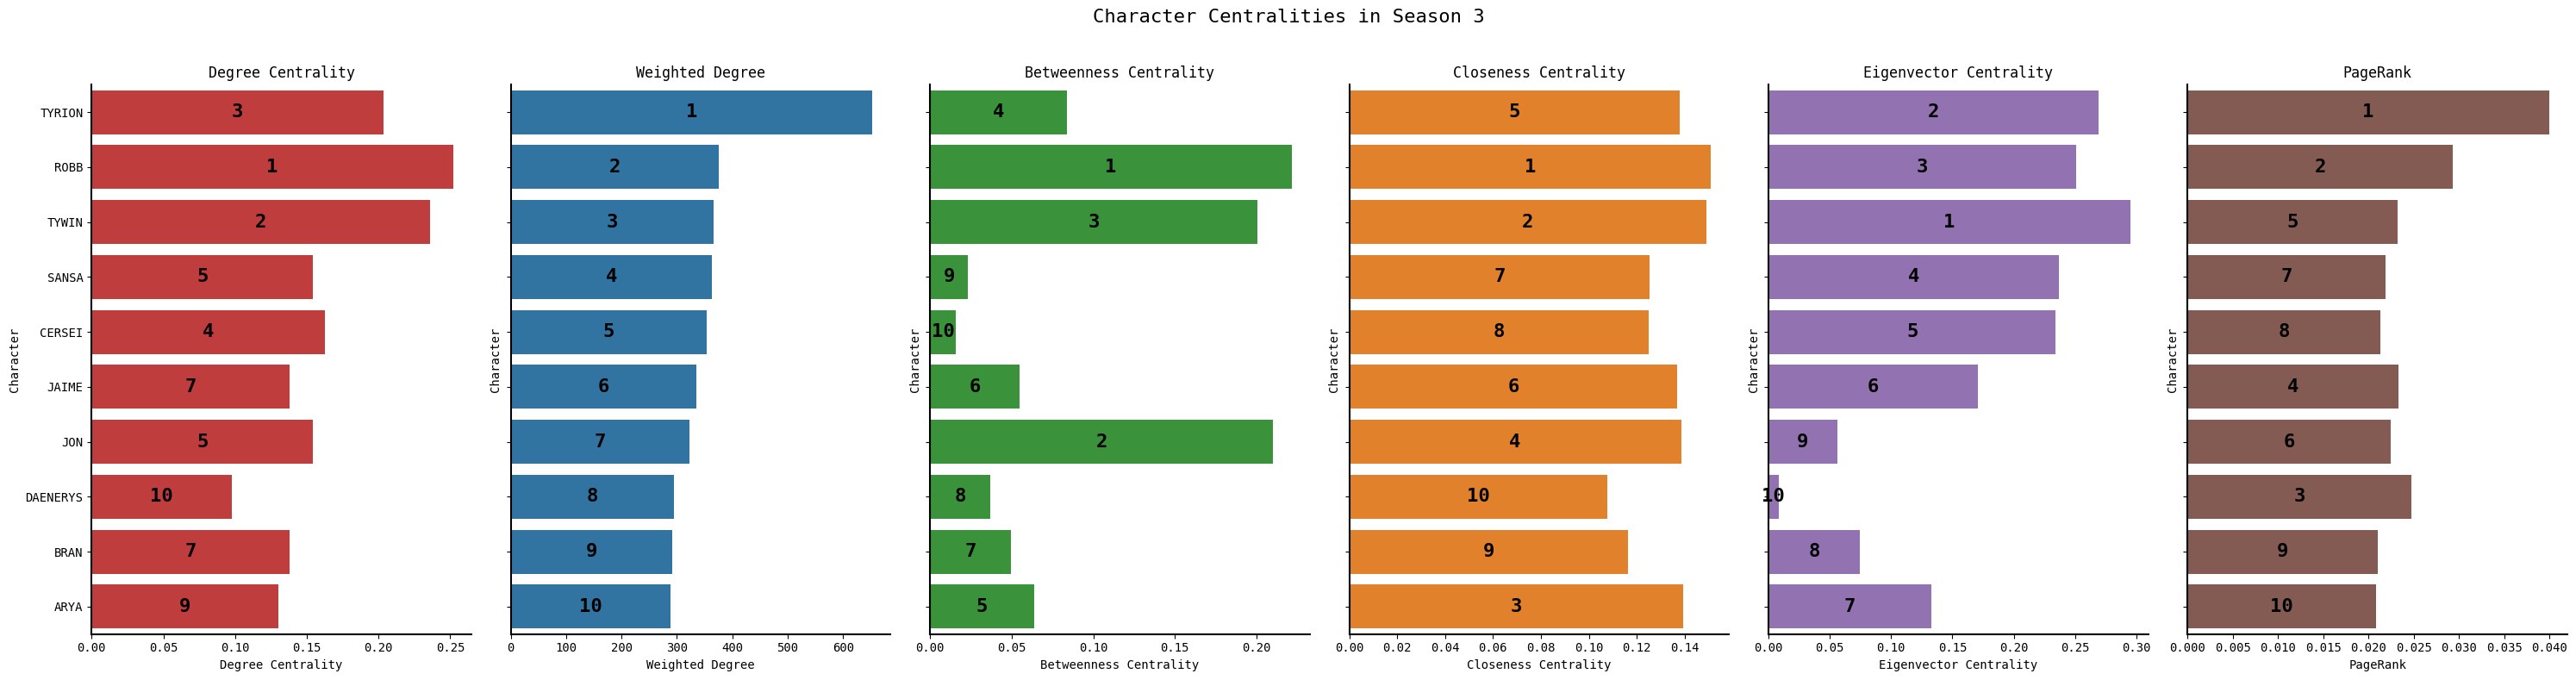

In [18]:
s3_top = centrality_measures(G3, s3_data, k, labels=labels, title='Character Centralities in Season 3')

## Main Character

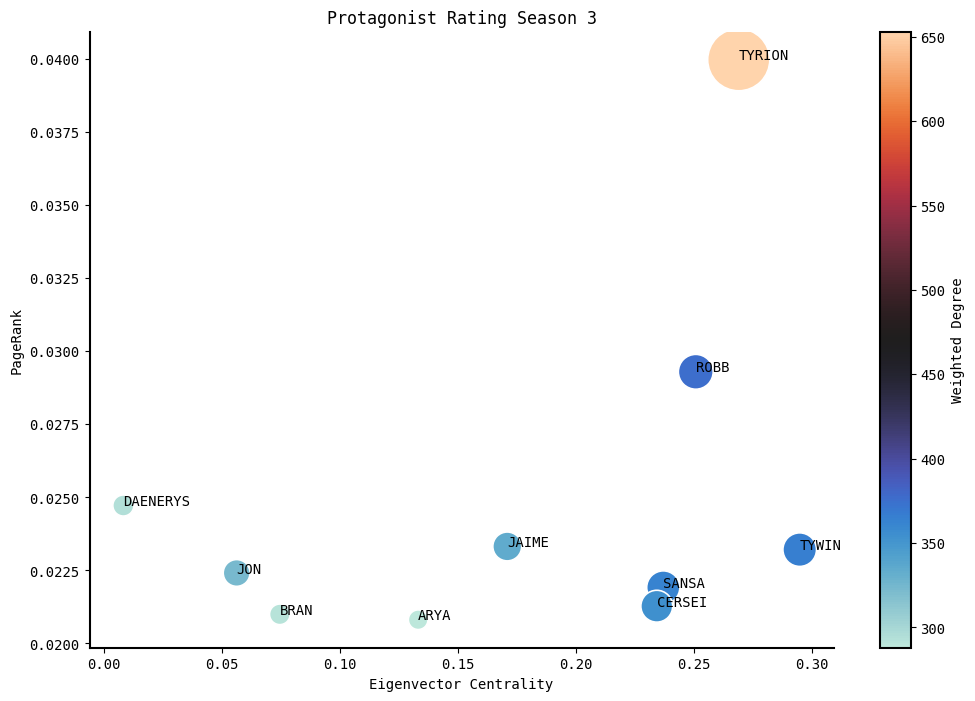

In [19]:
plot_protagonist_ratings(s3_top, 'Protagonist Rating Season 3')

In Season, while Robb Stark's story leads to the devastating Red Wedding, Tyrion Lannister is actually the most important character as his actions and decisions significantly influence the broader power dynamics in Westeros.

In King’s Landing, Tyrion navigates the complexities of his role as Master of Coin, where he faces the immense task of managing the crown's debt and maintaining the Lannister's grip on power. His political acumen is crucial in a season where the Lannisters are consolidating their hold on the Iron Throne. Tyrion also endures personal challenges, particularly through his forced marriage to Sansa Stark, which complicates his position within both his family and the court. Despite these challenges, Tyrion remains a key player in the Lannisters' strategy, working under the shadow of his father, Tywin, who controls much of the power in King’s Landing.

Tyrion’s influence in Season 3 extends beyond his administrative duties; he plays a central role in maintaining the Lannister's dominance during a time of war, manipulation, and fragile alliances. His ability to navigate these challenges with wit and pragmatism ensures the survival of his family’s power, making him more critical to the overall narrative than Robb, whose downfall, while dramatic, ultimately marks the end of the Stark's rebellion rather than a shift in ongoing power. Tyrion's actions have longer-lasting repercussions, both for the Lannisters and for the realm, solidifying his importance in the season.

>Tyrion Dominates Screentime Even As The Lannisters Push Him Aside

![](https://static1.cbrimages.com/wordpress/wp-content/uploads/2017/01/Tyrion-Lannister-from-Game-of-Thrones.jpg?q=50&fit=crop&w=750&dpr=1.5)

*Source:* [cbr.com](https://www.cbr.com/who-is-game-of-thrones-main-character-of-each-season/)

# Season 4

In [20]:
G4, s4_network, s4_data, num_edges, num_nodes = load_network('/kaggle/input/got-social-network/series/got-s4-edges.csv')
print(f'Number of Nodes: {num_nodes} - Number of Edges: {num_edges}')
s4_network.show('s4_network.html')

Number of Nodes: 172 - Number of Edges: 667
s4_network.html


## Communities

In the fourth season we have the following communities:
- Kings Landing (The Lannisters)
- Winterfell (Theon and the Boltons)
- Beyond the Wall (Bran)
- Castle Black (Jon and Sam)
- Dragonstone (Stannis)
- Mole´s Town (Kegs, Mully and Black Jack)
- The Riverlands (Arya and the Hound)
- Meereen (Daenerys)

In Season 4 of Game of Thrones, each community faces significant challenges and developments. In King's Landing, the Lannisters are shaken by the shocking death of King Joffrey Baratheon, who is poisoned during his wedding feast, known as the Purple Wedding. This event leads to Tyrion Lannister being accused of regicide and put on trial, ultimately demanding a trial by combat. 

In Winterfell, Theon Greyjoy, now broken and known as "Reek," is forced to assist Ramsay Bolton in capturing Moat Cailin, as the Boltons tighten their grip on the North. 

Beyond the Wall, Bran Stark continues his journey with Hodor and the Reeds, reaching the cave of the Three-Eyed Raven after a deadly encounter with wights, during which Jojen Reed is killed. 

At Castle Black, Jon Snow returns to warn the Night's Watch of the impending Wildling attack, leading to the intense Battle of Castle Black, where the Night's Watch manages to defend the Wall. 

Meanwhile, Stannis Baratheon, influenced by Melisandre's visions, prepares to aid the Night's Watch and ends the season by arriving at the Wall to defeat the Wildling army. 

In Mole's Town, a small settlement near Castle Black, the Wildlings, led by Tormund Giantsbane and Ygritte, launch a brutal raid, resulting in the destruction of the town and the deaths of many inhabitants. 

The Riverlands see Arya Stark continuing her journey with the Hound, facing various challenges, including a fight with Brienne of Tarth. The season concludes with Arya leaving the wounded Hound to die and boarding a ship to Braavos. 

In Meereen, Daenerys Targaryen successfully conquers the city, freeing the slaves and establishing her rule, but she struggles to maintain order and control her dragons, ultimately deciding to lock two of them in the catacombs when they become uncontrollable.

## Centrality Measures

,Character,Degree Centrality,Weighted Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank,Centrality Mean
0,TYRION,0.222222,876,0.078919,0.121095,0.287562,0.040367,146.125028
1,CERSEI,0.192982,619,0.085907,0.131621,0.270266,0.028735,103.284919
2,JAIME,0.169591,598,0.075733,0.129860,0.253863,0.027833,99.776147
3,TYWIN,0.163743,586,0.066556,0.126769,0.239205,0.027234,97.770584
4,JON,0.175439,542,0.039428,0.096805,0.024521,0.033543,90.394956
5,SANSA,0.181287,468,0.047421,0.118828,0.258950,0.023340,78.104971
6,OBERYN,0.146199,468,0.018242,0.088786,0.221271,0.021985,78.082747
7,JOFFREY,0.233918,376,0.196049,0.142164,0.294166,0.019832,62.814355
8,DAENERYS,0.093567,349,0.076914,0.104068,0.015841,0.030501,58.220149
9,SAM,0.146199,339,0.104206,0.119864,0.016154,0.021286,56.567951


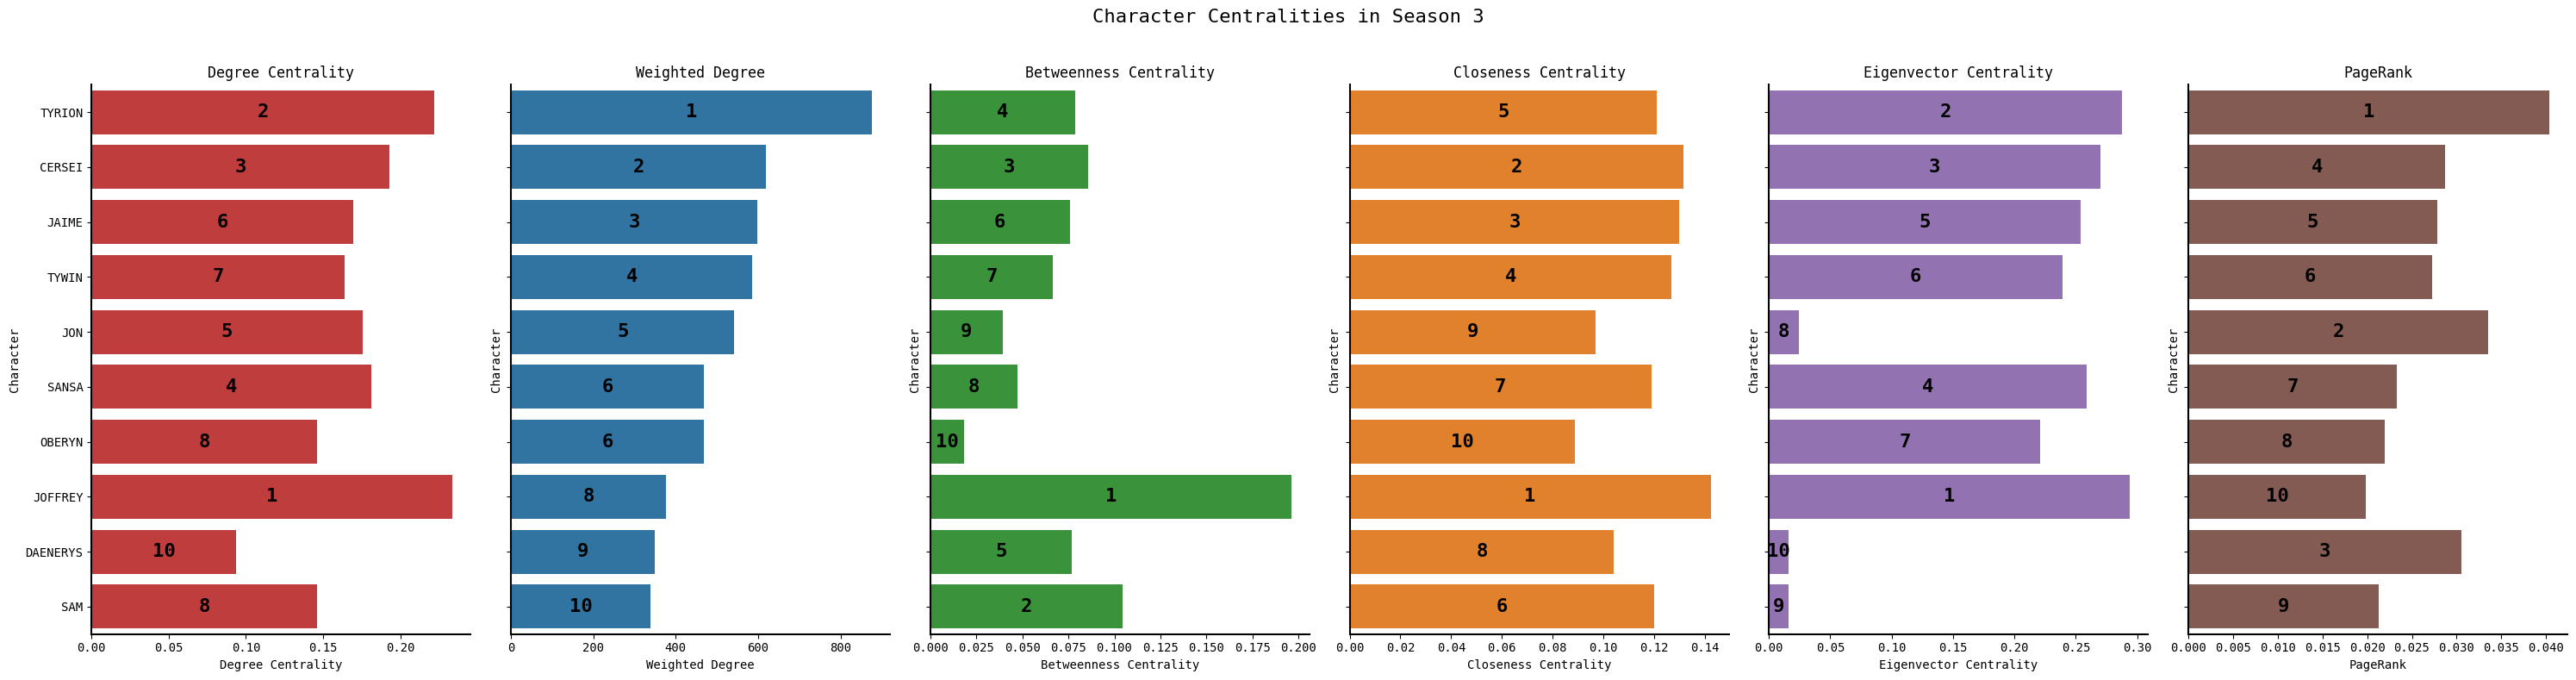

In [21]:
s4_top = centrality_measures(G4, s4_data, k, labels=labels, title='Character Centralities in Season 3')

## Main Character

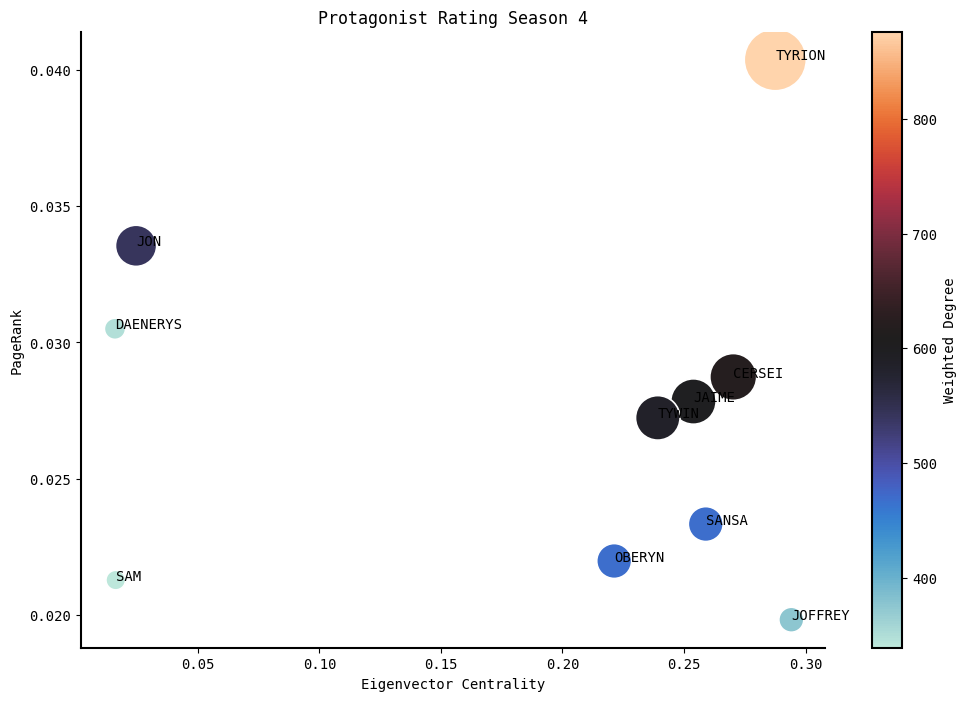

In [22]:
plot_protagonist_ratings(s4_top, 'Protagonist Rating Season 4')

In Season 4, Tyrion Lannister stands out as the most important character, with his storyline driving many of the season's key events. Accused of poisoning King Joffrey during the Purple Wedding, Tyrion becomes a scapegoat in a trial that exposes the deep fractures within the Lannister family and the corrupt nature of King's Landing. His trial by combat, which ends in Oberyn Martell's brutal death, only deepens his despair, leading to his powerful outburst in court, where he condemns the society that has long vilified him.

Tyrion's significance culminates in his escape from prison and confrontation with his father, Tywin Lannister. In an emotionally charged scene, Tyrion kills Tywin, an act of both revenge and liberation that dramatically shifts the political landscape in Westeros. This moment not only marks the culmination of Tyrion's long struggle against his father's tyranny but also destabilizes the Lannister family's hold on power.

Tyrion's journey in Season 4 encapsulates the show's central themes of power, betrayal, and the consequences of systemic injustice, making him the pivotal character whose actions have lasting repercussions on the narrative.

>Tyrion Faces Impossible Odds As He Is Accused Of Killing Joffrey

![](https://static1.cbrimages.com/wordpress/wp-content/uploads/2022/05/Tyrion-Lannister-from-Game-of-Thrones.jpg?q=50&fit=crop&w=750&dpr=1.5)

*Source:* [cbr.com](https://www.cbr.com/who-is-game-of-thrones-main-character-of-each-season/)

# Season 5

In [23]:
G5, s5_network, s5_data, num_edges, num_nodes = load_network('/kaggle/input/got-social-network/series/got-s5-edges.csv')
print(f'Number of Nodes: {num_nodes} - Number of Edges: {num_edges}')
s5_network.show('s5_network.html')

Number of Nodes: 119 - Number of Edges: 396
s5_network.html


## Communities

The communities in season 5 are a bit looser:
- Essos (Daenerys and Tyrion)
- Kings Landing (Cersei)
- Winterfell (Sansa and Littlefinger)
- Bravos (Arya)
- Nights Watch (Jon, Sam and Stannis)
- Dorne (Jaime and Bronn)

In Season 5, each community undergoes significant developments that continue to shape the intricate and volatile world of Westeros and Essos.

In Essos, Daenerys Targaryen faces growing unrest in Meereen as she struggles to maintain control over the city she liberated. Her efforts to rule justly are challenged by the insurgent group known as the Sons of the Harpy, leading to a series of violent confrontations. Meanwhile, Tyrion Lannister, who has fled Westeros after killing his father Tywin, finds himself in the company of Varys, journeying across the sea. He eventually meets Daenerys, offering his counsel and becoming a crucial advisor as she contemplates her future return to Westeros.

In King’s Landing, Cersei Lannister’s quest to maintain her power leads her to a dangerous alliance with the Faith Militant, a zealous religious group. Her plan to eliminate her enemies backfires when she is arrested by the group she empowered, leading to her public humiliation in the infamous "Walk of Atonement." Cersei's actions set off a chain of events that destabilize the political landscape of King's Landing.

At Winterfell, Sansa Stark, under Littlefinger’s guidance, is married to Ramsay Bolton, a union intended to secure the North for the Boltons. Sansa endures horrific abuse at Ramsay's hands, but her resilience begins to build, setting the stage for her eventual rise in later seasons. Littlefinger, ever the manipulator, continues to weave his web of schemes, aiming to further his own power.

In Braavos, Arya Stark begins her training with the Faceless Men, a secretive guild of assassins. She struggles with abandoning her identity and past grudges, particularly her desire for revenge, as she learns the deadly arts of the guild.

At the Wall, Jon Snow is elected Lord Commander of the Night's Watch, a position that tests his leadership as he grapples with the growing threat of the White Walkers and the uneasy alliance with the Wildlings. Meanwhile, Stannis Baratheon, determined to claim the Iron Throne, makes the fateful decision to march on Winterfell, a campaign that ultimately ends in his defeat and death. Samwell Tarly, along with Gilly, leaves for the Citadel, setting out to become a maester and gather knowledge to aid in the fight against the White Walkers.

In Dorne, Jaime Lannister and Bronn travel to retrieve Myrcella Baratheon, but their mission is fraught with danger as they encounter the vengeful Sand Snakes and Prince Doran Martell. The intrigue in Dorne ultimately leads to tragedy, further complicating the political tensions between the Martells and the Lannisters.

## Centrality Measures

,Character,Degree Centrality,Weighted Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank,Centrality Mean
0,CERSEI,0.254237,590,0.134630,0.118118,0.240916,0.049071,98.466162
1,JON,0.211864,552,0.202629,0.115122,0.270321,0.055277,92.142535
2,TYRION,0.161017,480,0.089993,0.112919,0.104248,0.032759,80.083489
3,DAENERYS,0.118644,413,0.048674,0.105357,0.057370,0.028834,68.893147
4,STANNIS,0.203390,390,0.266296,0.126609,0.317602,0.035589,65.158248
5,SANSA,0.177966,361,0.221219,0.134396,0.193537,0.033242,60.293393
6,JAIME,0.144068,328,0.122262,0.118593,0.129570,0.026551,54.756841
7,SAM,0.169492,313,0.059161,0.082230,0.234649,0.033455,52.263164
8,LITTLEFINGER,0.211864,290,0.195001,0.127706,0.235552,0.027909,48.466339
9,JORAH,0.093220,244,0.044155,0.100855,0.062447,0.016209,40.719481


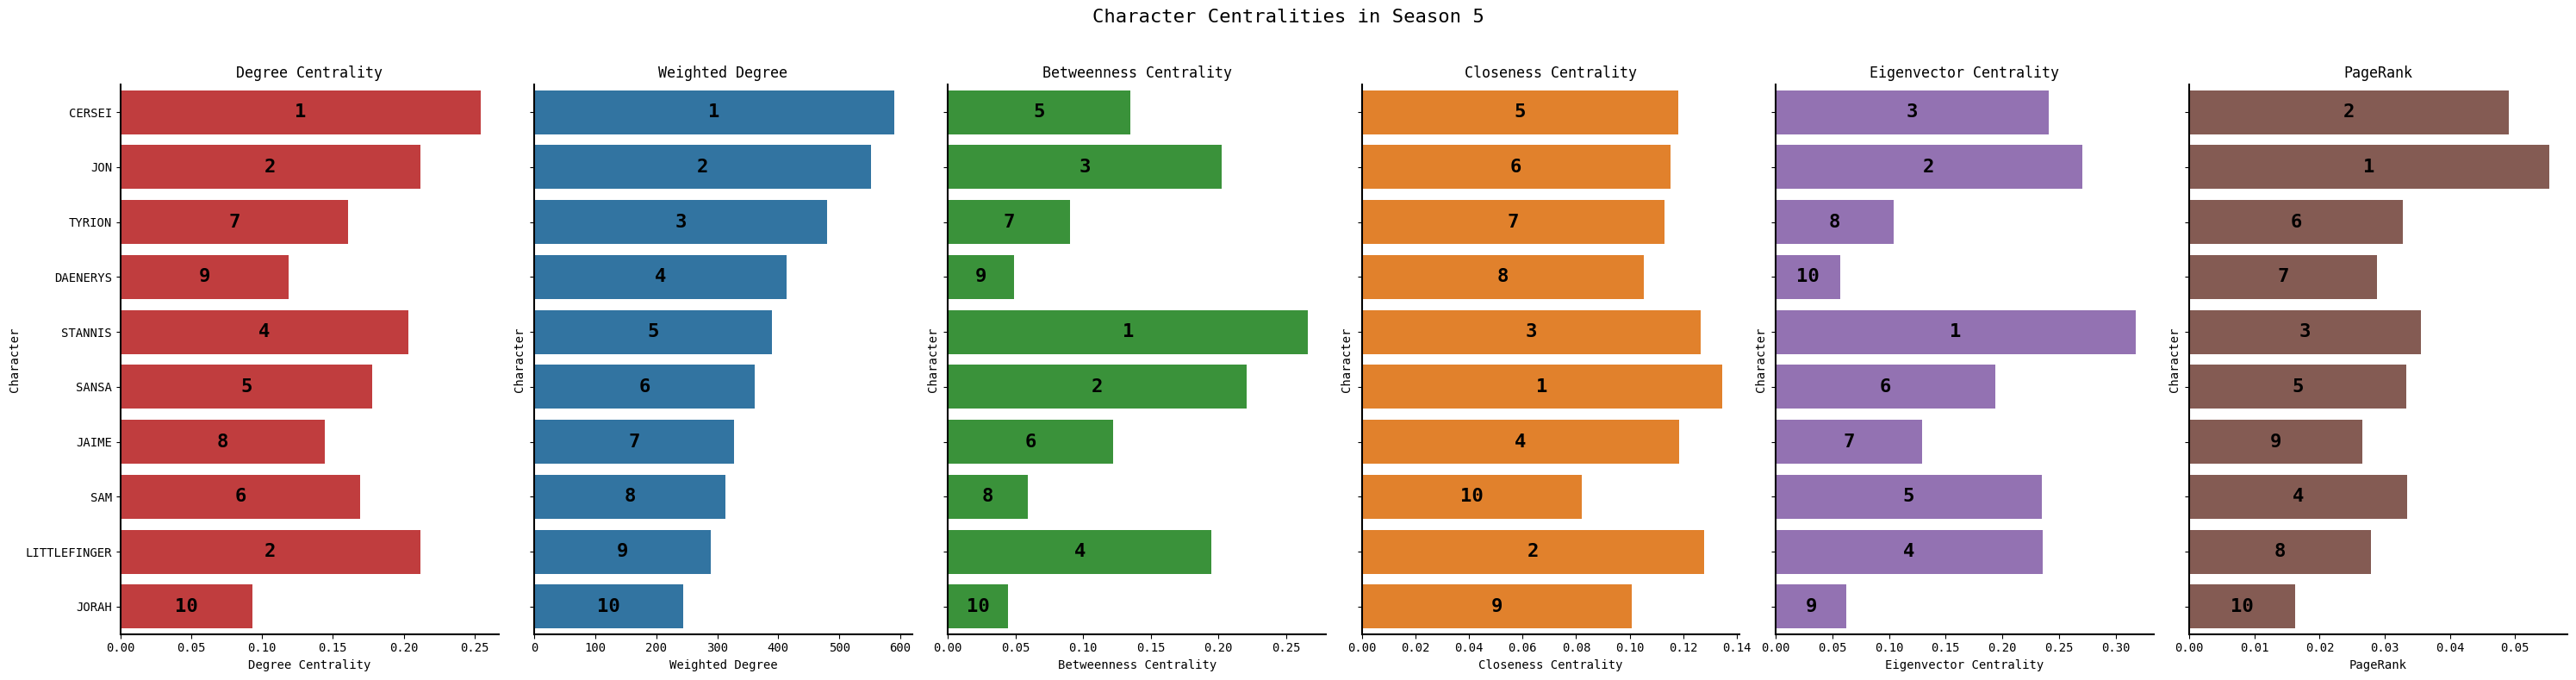

In [24]:
s5_top = centrality_measures(G5, s5_data, k, labels=labels, title='Character Centralities in Season 5')

## Main Character

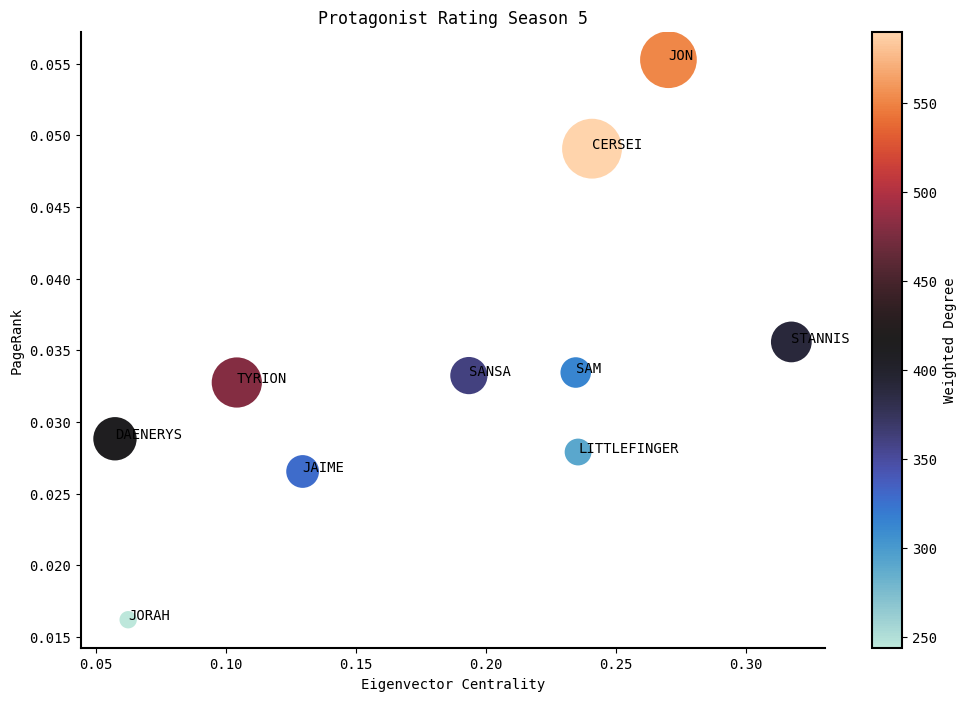

In [25]:
plot_protagonist_ratings(s5_top, 'Protagonist Rating Season 5')

In Season 5 of Game of Thrones, Cersei Lannister emerges as the most important character, wielding significant influence over the unfolding events in King’s Landing. Her actions, driven by a desire to consolidate her power, lead her to ally with the Faith Militant, a radical religious group. This alliance initially seems advantageous, but it backfires dramatically when the Faith Militant arrests her, resulting in her public humiliation during the "Walk of Atonement." This crucial moment not only marks the peak of Cersei's downfall but also destabilizes the political landscape of the capital.

While Jon Snow’s leadership at the Wall is indeed vital, as he grapples with the threats from the White Walkers and the complex dynamics of the Night’s Watch and Wildlings, Cersei’s influence extends far beyond her immediate environment. Her manipulations in King's Landing create a power vacuum and set off a chain reaction of political turmoil that affects the entire realm. Cersei's downfall, marked by her arrest and subsequent humiliation, has far-reaching consequences for the Lannister dynasty and the broader political stability of Westeros.

Cersei’s impact is more pronounced than Jon’s in Season 5 because her actions directly alter the balance of power in King’s Landing and beyond, leading to significant shifts in alliances and power structures. Her strategic errors and eventual fall from grace are central to the season’s major developments, making her the pivotal character whose influence and decisions resonate throughout the series.

>Cersei Fights For Control Of Her Last Son

![](https://static1.cbrimages.com/wordpress/wp-content/uploads/2017/01/Cerseis-Walk-Of-Shame.jpg?q=50&fit=crop&w=750&dpr=1.5)

*Source:* [cbr.com](https://www.cbr.com/who-is-game-of-thrones-main-character-of-each-season/)

# Season 6

In [26]:
G6, s6_network, s6_data, num_edges, num_nodes = load_network('/kaggle/input/got-social-network/series/got-s6-edges.csv')
print(f'Number of Nodes: {num_nodes} - Number of Edges: {num_edges}')
s6_network.show('s6_network.html')

Number of Nodes: 142 - Number of Edges: 541
s6_network.html


## Communities

The communities in season 6 are the following:
- The Reach and Oldtown (Sam and Gilly)
- King’s Landing and the Riverlands (Cersei, Jaime)
- Dorne (Ellaria)
- The North (Sansa, Jon, Davos, Ramsay)
- The Riverlands (Hound)
- Beyond the Wall and Winterfell Flashbacks (Bran)
- The Ironborn (Theon)
- Essos (Daenerys, Tyrion)
- Braavos (Arya)

In Season 6, each community undergoes pivotal changes that significantly impact the broader storyline.

In the Reach and Oldtown, Samwell Tarly and Gilly arrive at the Citadel in Oldtown, where Sam begins his training to become a maester. This journey is crucial as it sets up Sam’s future role in uncovering knowledge about the White Walkers. Meanwhile, Gilly adapts to life in Oldtown, and the two face their own challenges as they integrate into this new environment.

In King’s Landing and the Riverlands, Cersei Lannister continues her quest for power, using the chaos and instability following her public humiliation to her advantage. She orchestrates a dramatic coup, leading to the destruction of the Great Sept of Baelor with wildfire, eliminating many of her enemies and securing her position as Queen. Jaime Lannister, dealing with his own internal conflicts and shifting loyalties, grapples with the consequences of Cersei’s ruthless actions, which include the fracturing of their family’s alliances.

In Dorne, Ellaria Sand leads a rebellion against the Lannisters and seeks revenge for the death of Oberyn Martell. Her actions highlight the continued unrest and desire for retribution in Dorne, but her influence is more limited compared to the broader political machinations elsewhere.

In the North, the major conflict centers around the struggle for Winterfell. Jon Snow and Sansa Stark, with the help of allies like Davos Seaworth, fight to reclaim their home from Ramsay Bolton. This culminates in the Battle of the Bastards, a pivotal and brutal confrontation that restores Winterfell to the Stark family and solidifies Jon’s position as a key leader in the North.

In the Riverlands, the Hound, now on a path of redemption, encounters the Brotherhood Without Banners and aids in their quest for justice. His journey reflects his evolving character and the broader theme of redemption throughout the series.

Beyond the Wall and in Winterfell flashbacks, Bran Stark, with the guidance of the Three-Eyed Raven, explores the past through his visions. These flashbacks reveal critical information about the history of Westeros, including the origins of the White Walkers and the events leading up to the present conflicts.

In the Ironborn, Theon Greyjoy continues his struggle to reclaim his identity and support his sister, Yara, as they navigate the political intrigue and power struggles within their house.

In Essos, Daenerys Targaryen makes significant strides in her quest for the Iron Throne. She consolidates power in Meereen, defeats her rivals, and forms an alliance with Tyrion Lannister. Her journey towards Westeros gains momentum as she prepares her forces for the impending conquest.

In Braavos, Arya Stark continues her training with the Faceless Men, honing her skills as an assassin. Her quest for vengeance leads her to exact retribution on those who wronged her family, marking her transition from a girl seeking justice to a formidable force.

## Centrality Measures

,Character,Degree Centrality,Weighted Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank,Centrality Mean
0,JON,0.219858,598,0.217324,0.102078,0.257546,0.039866,99.806112
1,SANSA,0.283688,549,0.157200,0.108430,0.368173,0.035819,91.658885
2,TYRION,0.184397,442,0.079216,0.100123,0.200951,0.030571,73.765876
3,JAIME,0.170213,407,0.140642,0.100524,0.147191,0.029125,67.931282
4,DAVOS,0.163121,394,0.030159,0.089101,0.212111,0.025908,65.753400
5,CERSEI,0.191489,329,0.099261,0.102411,0.199373,0.024458,54.936166
6,DAENERYS,0.127660,289,0.091895,0.075757,0.048584,0.021663,48.227593
7,ARYA,0.120567,275,0.015560,0.096652,0.166664,0.017904,45.902891
8,BRAN,0.120567,273,0.105690,0.100928,0.097496,0.020856,45.574256
9,MARGAERY,0.120567,264,0.024500,0.093344,0.151835,0.017909,44.068026


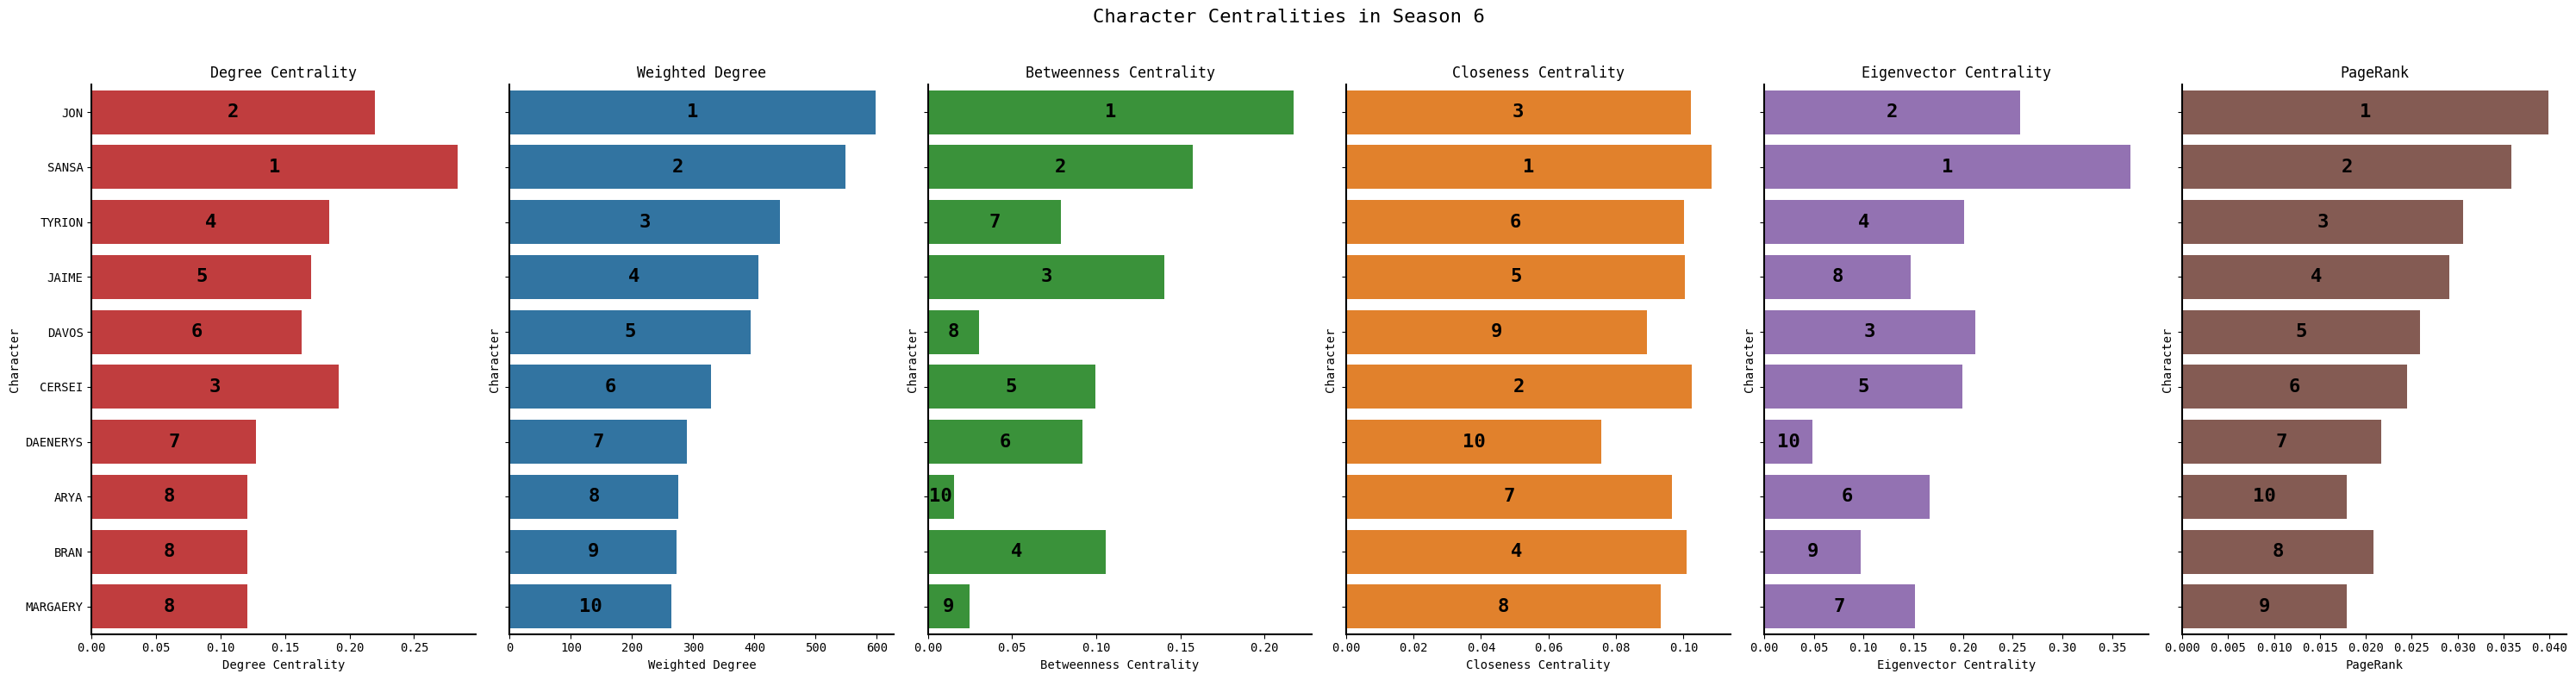

In [27]:
s6_top = centrality_measures(G6, s6_data, k, labels=labels, title='Character Centralities in Season 6')

## Main Character

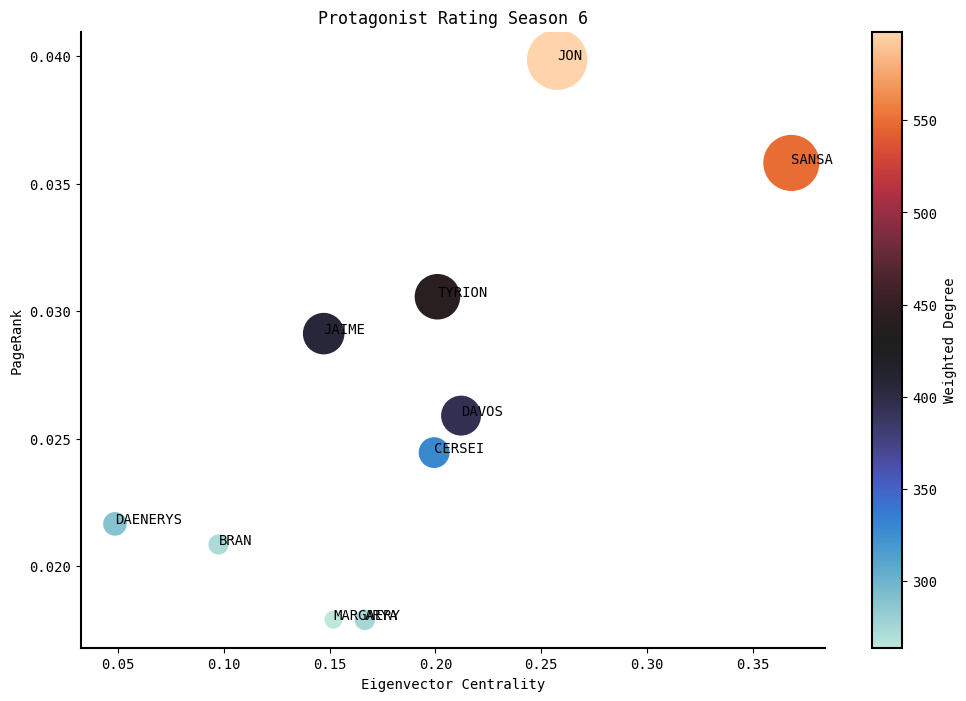

In [28]:
plot_protagonist_ratings(s6_top, 'Protagonist Rating Season 6')

In Season 6 of Game of Thrones, Jon Snow stands out as the most important character, though his story is closely intertwined with Sansa Stark’s. Jon’s pivotal role in reclaiming Winterfell from Ramsay Bolton, culminating in the Battle of the Bastards, solidifies his position as a major leader in the North. His military and leadership skills prove crucial in restoring Winterfell to the Stark family, reuniting them with their ancestral home, and rallying Northern houses against the threats looming on the horizon.

Sansa Stark’s contributions are also significant. Her experiences under Ramsay Bolton's cruelty and her strategic acumen, gained through her time with Petyr Baelish and her survival in King's Landing, make her a key ally to Jon. Sansa’s role in the North is vital, as she provides valuable insights and helps strategize their efforts to reclaim their home. Her personal growth and understanding of political maneuvering complement Jon’s more straightforward leadership style, making them a powerful duo in the fight against Ramsay and in the subsequent efforts to unite the North.

While Cersei Lannister’s dramatic actions in King's Landing, such as the destruction of the Great Sept of Baelor, shift the power dynamics in Westeros, Jon Snow’s leadership in the North is more directly impactful to the series’ ongoing narrative. His success in the North not only sets the stage for future conflicts but also establishes him as a central figure in the struggle against the White Walkers, making him the most pivotal character of Season 6.

>Jon Snow Is Resurrected and Retakes The North

![](https://static1.cbrimages.com/wordpress/wp-content/uploads/2022/04/Jon-Snow-Targaryen-Game-of-Thrones.jpg?q=50&fit=crop&w=750&dpr=1.5)

*Source:* [cbr.com](https://www.cbr.com/who-is-game-of-thrones-main-character-of-each-season/)

# Season 7

In [29]:
G7, s7_network, s7_data, num_edges, num_nodes = load_network('/kaggle/input/got-social-network/series/got-s7-edges.csv')
print(f'Number of Nodes: {num_nodes} - Number of Edges: {num_edges}')
s7_network.show('s7_network.html')

Number of Nodes: 81 - Number of Edges: 412
s7_network.html


## Communities

In season 7 we have four communities:
- Kings Landing
- Wintefell
- Dragonstone
- The Northern Expedition

In Season 7 of Game of Thrones, the key communities each play a critical role in the unfolding power struggles and strategic maneuvers that set the stage for the series' conclusion.

In King's Landing, Cersei Lannister consolidates her control over the Iron Throne after the dramatic events of the previous season. She deftly manages the political landscape, focusing on fortifying her position against her rivals, including Daenerys Targaryen and Jon Snow. Cersei’s manipulations and alliances are central to the political intrigue of the season, as she prepares for the impending conflicts and seeks to outmaneuver her enemies.

At Winterfell, Jon Snow and Sansa Stark work to unify the North and prepare for the looming threat of the White Walkers. Jon's leadership is pivotal as he rallies the Northern houses and prepares for the coming war, while Sansa's political acumen and experience become increasingly vital in navigating the complexities of Northern politics and ensuring their survival.

On Dragonstone, Daenerys Targaryen continues her campaign to reclaim the Iron Throne. She solidifies her position as a major player by forging alliances with key characters like Tyrion Lannister and Jon Snow, who come to Dragonstone to seek her support in the fight against the White Walkers. Daenerys’s strategic decisions and military campaigns are crucial in the season as she works to build her army and prepare for the invasion of Westeros.

The Northern Expedition, which involves Jon Snow and his team venturing beyond the Wall to capture a wight, becomes one of the most pivotal plotlines. This expedition, intended to convince Cersei of the threat posed by the White Walkers, highlights the growing alliance between Jon and Daenerys. It leads to a dramatic confrontation with the Night King and his army, ultimately resulting in the capture of a wight and the unification of various factions around the common threat.

## Centrality Measures

,Character,Degree Centrality,Weighted Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank,Centrality Mean
0,JON,0.537500,968,0.136042,0.175824,0.285747,0.079398,161.535752
1,DAENERYS,0.425000,733,0.197656,0.192308,0.252552,0.058223,122.354290
2,TYRION,0.425000,693,0.061680,0.165289,0.264335,0.053211,115.661586
3,CERSEI,0.387500,588,0.047669,0.168776,0.231851,0.050735,98.147755
4,SANSA,0.300000,542,0.103133,0.169851,0.158660,0.054506,90.464358
5,JAIME,0.275000,521,0.058712,0.173536,0.191398,0.042849,86.956916
6,DAVOS,0.337500,361,0.052341,0.177384,0.240078,0.027732,60.305839
7,HOUND,0.287500,327,0.017707,0.160000,0.206959,0.025821,54.616331
8,ARYA,0.225000,317,0.027226,0.136054,0.111075,0.033393,52.922125
9,JORAH,0.275000,307,0.017127,0.160000,0.173423,0.027655,51.275534


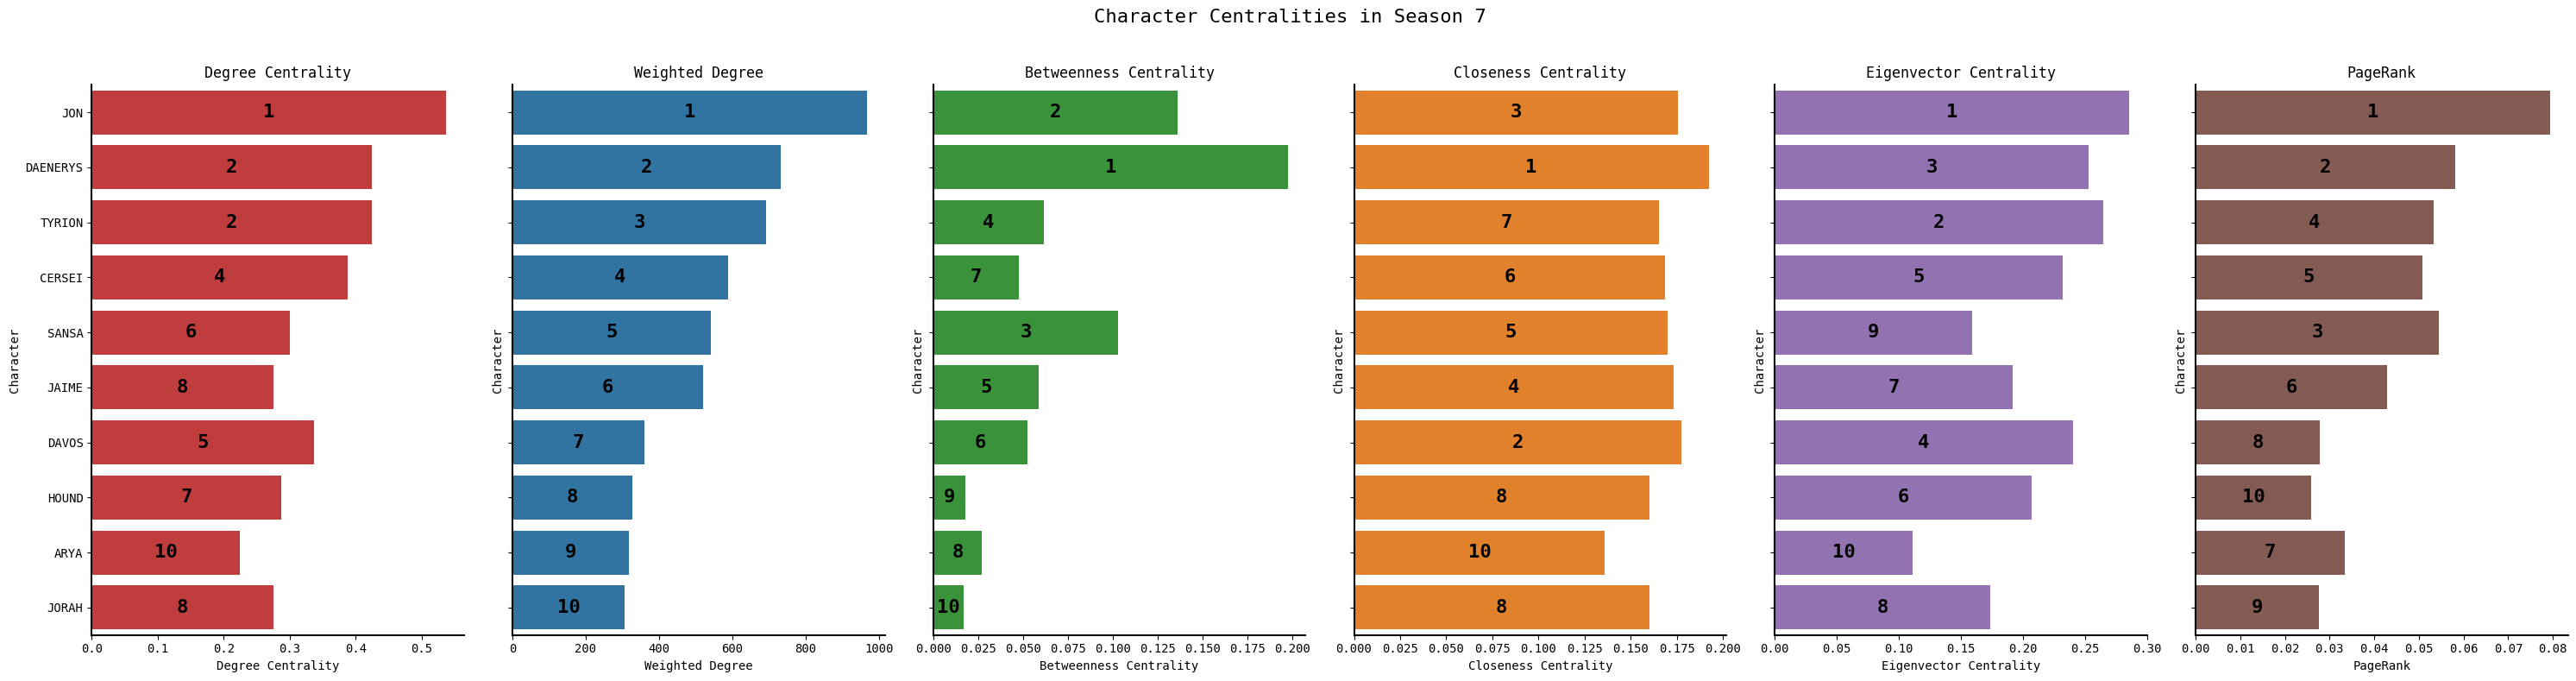

In [30]:
s7_top = centrality_measures(G7, s7_data, k, labels=labels, title='Character Centralities in Season 7')

## Main Character

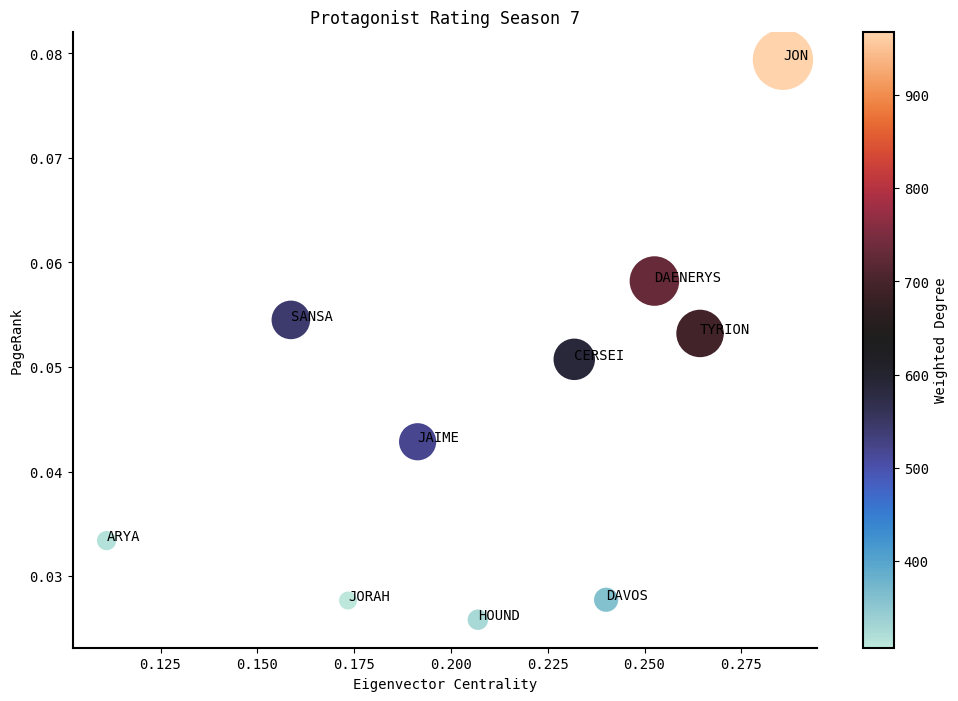

In [31]:
plot_protagonist_ratings(s7_top, 'Protagonist Rating Season 7')

In Season 7, Jon Snow emerges as the most important character. His leadership in the North, his alliance with Daenerys, and his crucial role in the Northern Expedition drive the season’s central conflicts and strategies. Jon’s actions not only influence the immediate power struggles but also set the stage for the final battle against the White Walkers. His decisions and alliances are pivotal in uniting the disparate factions of Westeros and preparing for the ultimate confrontation, making him the central figure whose choices have the most significant impact on the season’s developments.

>Jon Snow Tries To Save Westeros From The Night King

![](https://static1.cbrimages.com/wordpress/wp-content/uploads/2019/07/Game-of-Thrones-Jon-Snow.jpg?q=50&fit=crop&w=750&dpr=1.5)

*Source:* [cbr.com](https://www.cbr.com/who-is-game-of-thrones-main-character-of-each-season/)

# Season 8

In [32]:
G8, s8_network, s8_data, num_edges, num_nodes = load_network('/kaggle/input/got-social-network/series/got-s8-edges.csv')
print(f'Number of Nodes: {num_nodes} - Number of Edges: {num_edges}')
s8_network.show('s8_network.html')

Number of Nodes: 74 - Number of Edges: 553
s8_network.html


## Communities

In Season 8 of Game of Thrones, the remaining communities play crucial roles as the series reaches its dramatic conclusion.

At Winterfell, the focus is on the epic Battle of Winterfell, where Jon Snow, Daenerys Targaryen, and their allies face off against the Night King and his army of the dead. This battle is a pivotal moment in the season, as it determines the fate of the North and the entire realm. Following their victory, Winterfell becomes the central base for the characters as they prepare for the final showdown with Cersei Lannister in King's Landing. The aftermath of the battle sees significant character developments, including Arya Stark’s journey and Bran Stark’s eventual rise to a crucial role in the new order of Westeros.

In King’s Landing, the political and military conflict reaches its climax. Cersei Lannister, who remains entrenched in her power, faces a dire siege from Daenerys and her forces. The city is subjected to intense and destructive warfare, ultimately leading to Cersei’s downfall. The destruction of King's Landing is a key turning point, reshaping the power dynamics of Westeros and setting the stage for the final resolution of the series.

Dragonstone serves as a strategic headquarters for Daenerys Targaryen and her advisors, including Tyrion Lannister. The island is crucial as Daenerys plans her assault on King’s Landing and makes pivotal decisions that drive the final conflict. Dragonstone’s strategic significance highlights Daenerys’s ambitions and the final stages of her campaign for the Iron Throne.

In Beyond the Wall, the aftermath of the Night King’s defeat is briefly revisited, emphasizing the continued presence of the wilderness and the remaining threats in the North. This area reflects the broader consequences of the war and the ongoing challenges facing the characters as they transition to a new era.

## Centrality Measures

,Character,Degree Centrality,Weighted Degree,Betweenness Centrality,Closeness Centrality,Eigenvector Centrality,PageRank,Centrality Mean
0,TYRION,0.561644,1062,0.039260,0.177064,0.217896,0.076165,177.178672
1,JON,0.493151,914,0.039863,0.169252,0.189663,0.066622,152.493092
2,DAENERYS,0.561644,843,0.151875,0.190234,0.198739,0.063875,140.694395
3,JAIME,0.438356,586,0.078914,0.176611,0.184975,0.043346,97.820367
4,SANSA,0.547945,577,0.075232,0.190759,0.215813,0.042951,96.345450
5,ARYA,0.534247,509,0.082881,0.192353,0.213827,0.041231,85.010756
6,BRIENNE,0.465753,476,0.029099,0.173942,0.206062,0.035446,79.485050
7,SAM,0.575342,461,0.106811,0.183656,0.217152,0.037663,77.020104
8,GREY_WORM,0.520548,454,0.021132,0.169668,0.214918,0.033737,75.826667
9,TORMUND,0.397260,417,0.010059,0.163637,0.171241,0.031381,69.628930


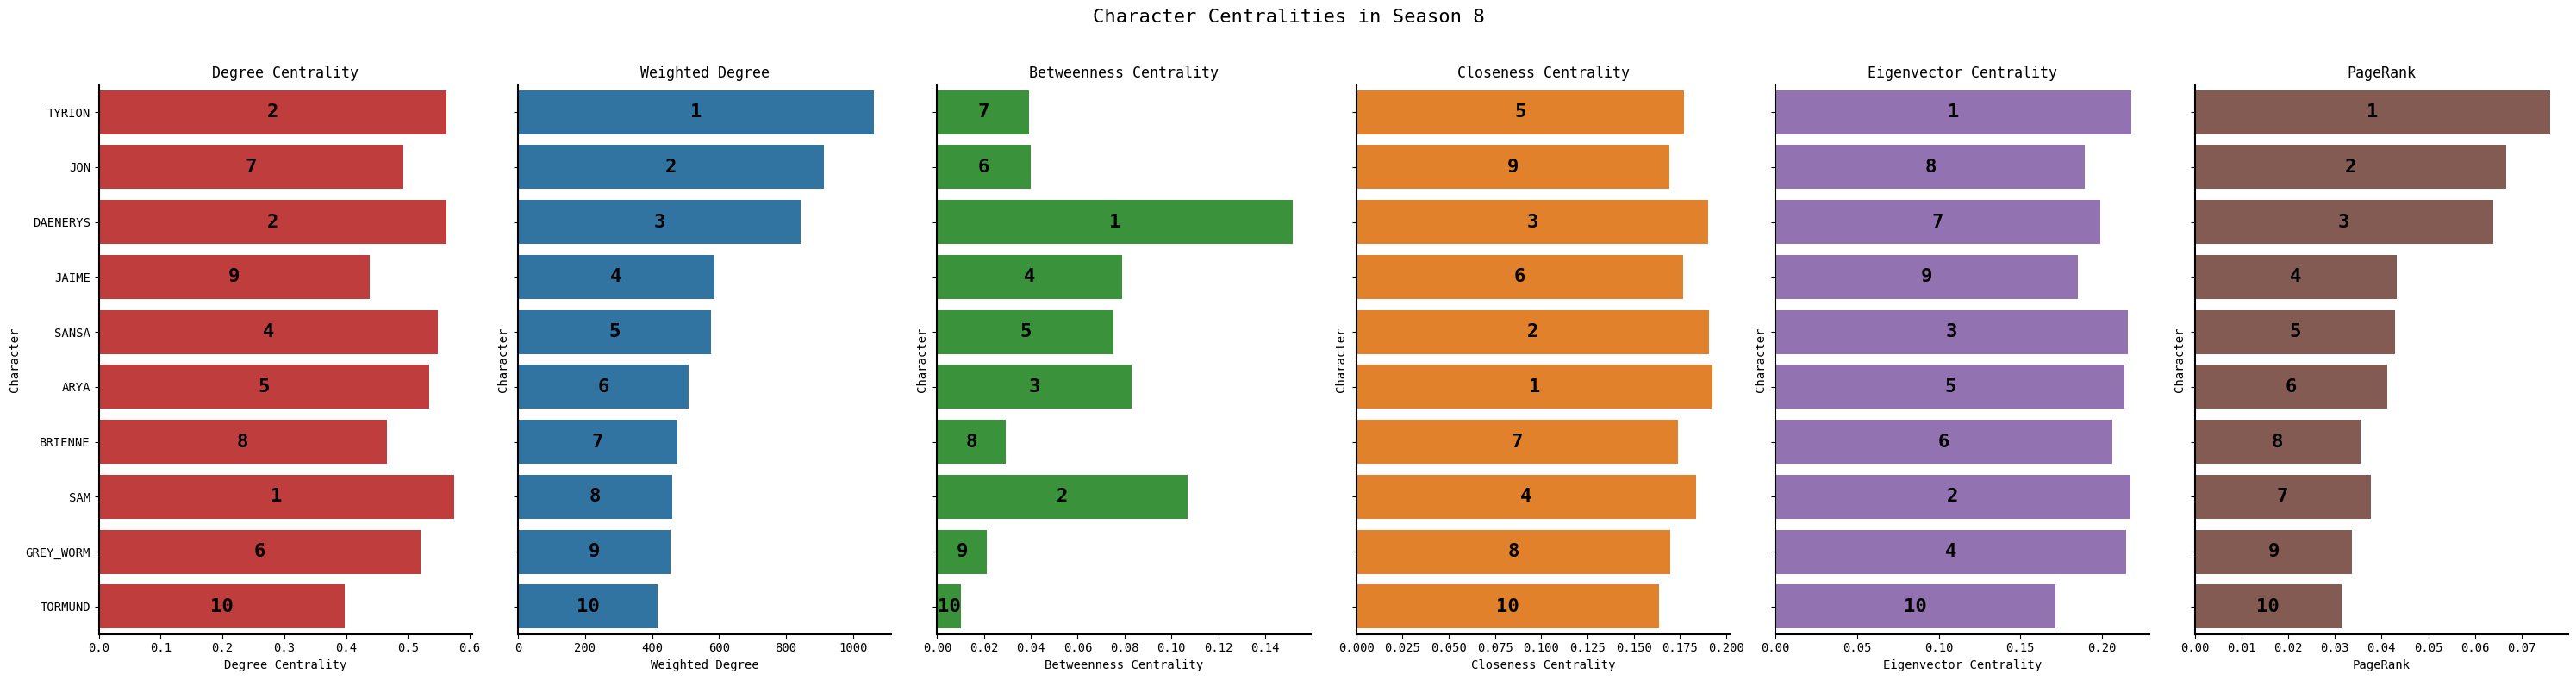

In [33]:
s8_top = centrality_measures(G8, s8_data, k, labels=labels, title='Character Centralities in Season 8')

## Main Character

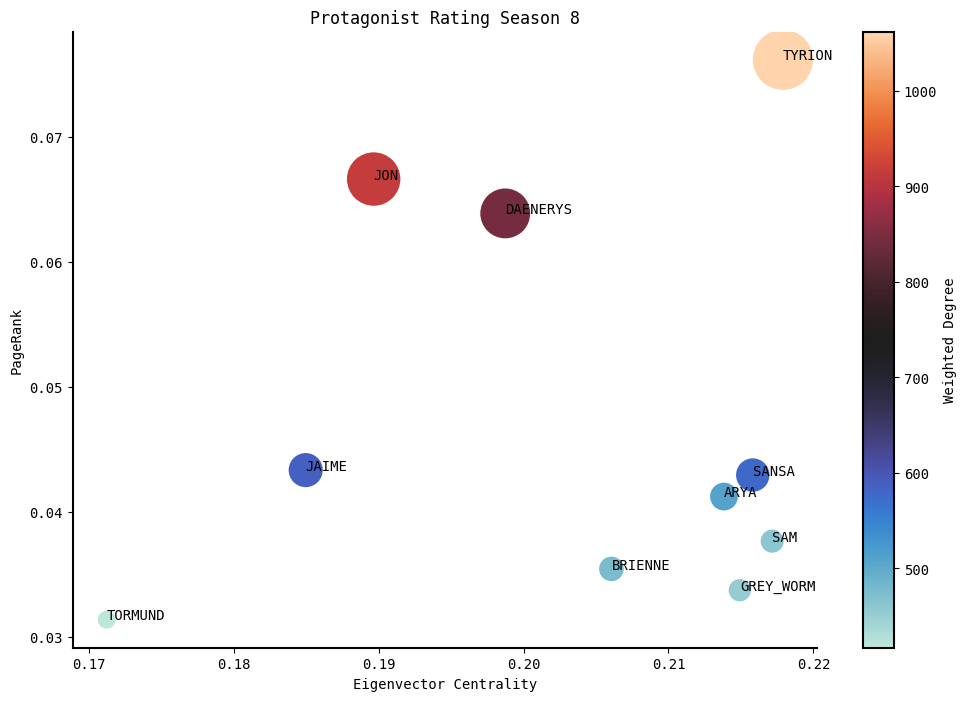

In [34]:
plot_protagonist_ratings(s8_top, 'Protagonist Rating Season 8')

In Season 8, Jon Snow emerges as the most important character. His leadership and bravery in the Battle of Winterfell are pivotal in defeating the Night King, securing the North and eliminating the existential threat to the realm. Jon’s actions are crucial as he navigates the complex power dynamics between himself, Daenerys, and Tyrion. His moral decisions and ultimate confrontation with Daenerys, driven by his concern for the realm and the future of Westeros, define his role as the central figure. Jon’s victory in the final struggle and his return to the Night's Watch highlight his importance in shaping the series' conclusion and the new order of Westeros.

>Jon Snow Watches As Daenerys Descends Into Madness

![](https://static1.cbrimages.com/wordpress/wp-content/uploads/2022/04/Game-of-Thrones-Daenerys-Dies-in-Jon-Snows-Arms.jpeg?q=50&fit=crop&w=750&dpr=1.5)

*Source:* [cbr.com](https://www.cbr.com/who-is-game-of-thrones-main-character-of-each-season/)

# Character Relevance - A Timeline
Throughout Game of Thrones, the relevance of characters shifts dramatically as the series progresses, reflecting the evolving power dynamics and narrative arcs that define the show's epic story. This timeline captures how the importance of key figures such as Jon Snow, Daenerys Targaryen, Tyrion Lannister, and others fluctuates from season to season, illustrating their central roles in shaping the fate of Westeros and beyond. By tracing their prominence and influence across different seasons, we gain insight into how individual actions and decisions drive the overarching plot and contribute to the ultimate resolution of the series. This visualization highlights the complex interplay between characters and their impact on the unfolding drama, offering a clearer understanding of their contributions to the epic saga.

In [35]:
# Make one big dataframe
dfs = [s1_top, s2_top, s3_top, s4_top, s5_top, s6_top, s7_top, s8_top]
for i, df in enumerate(dfs, start=1):
    df['Season'] = f'Season {i}'
all_seasons = pd.concat(dfs)

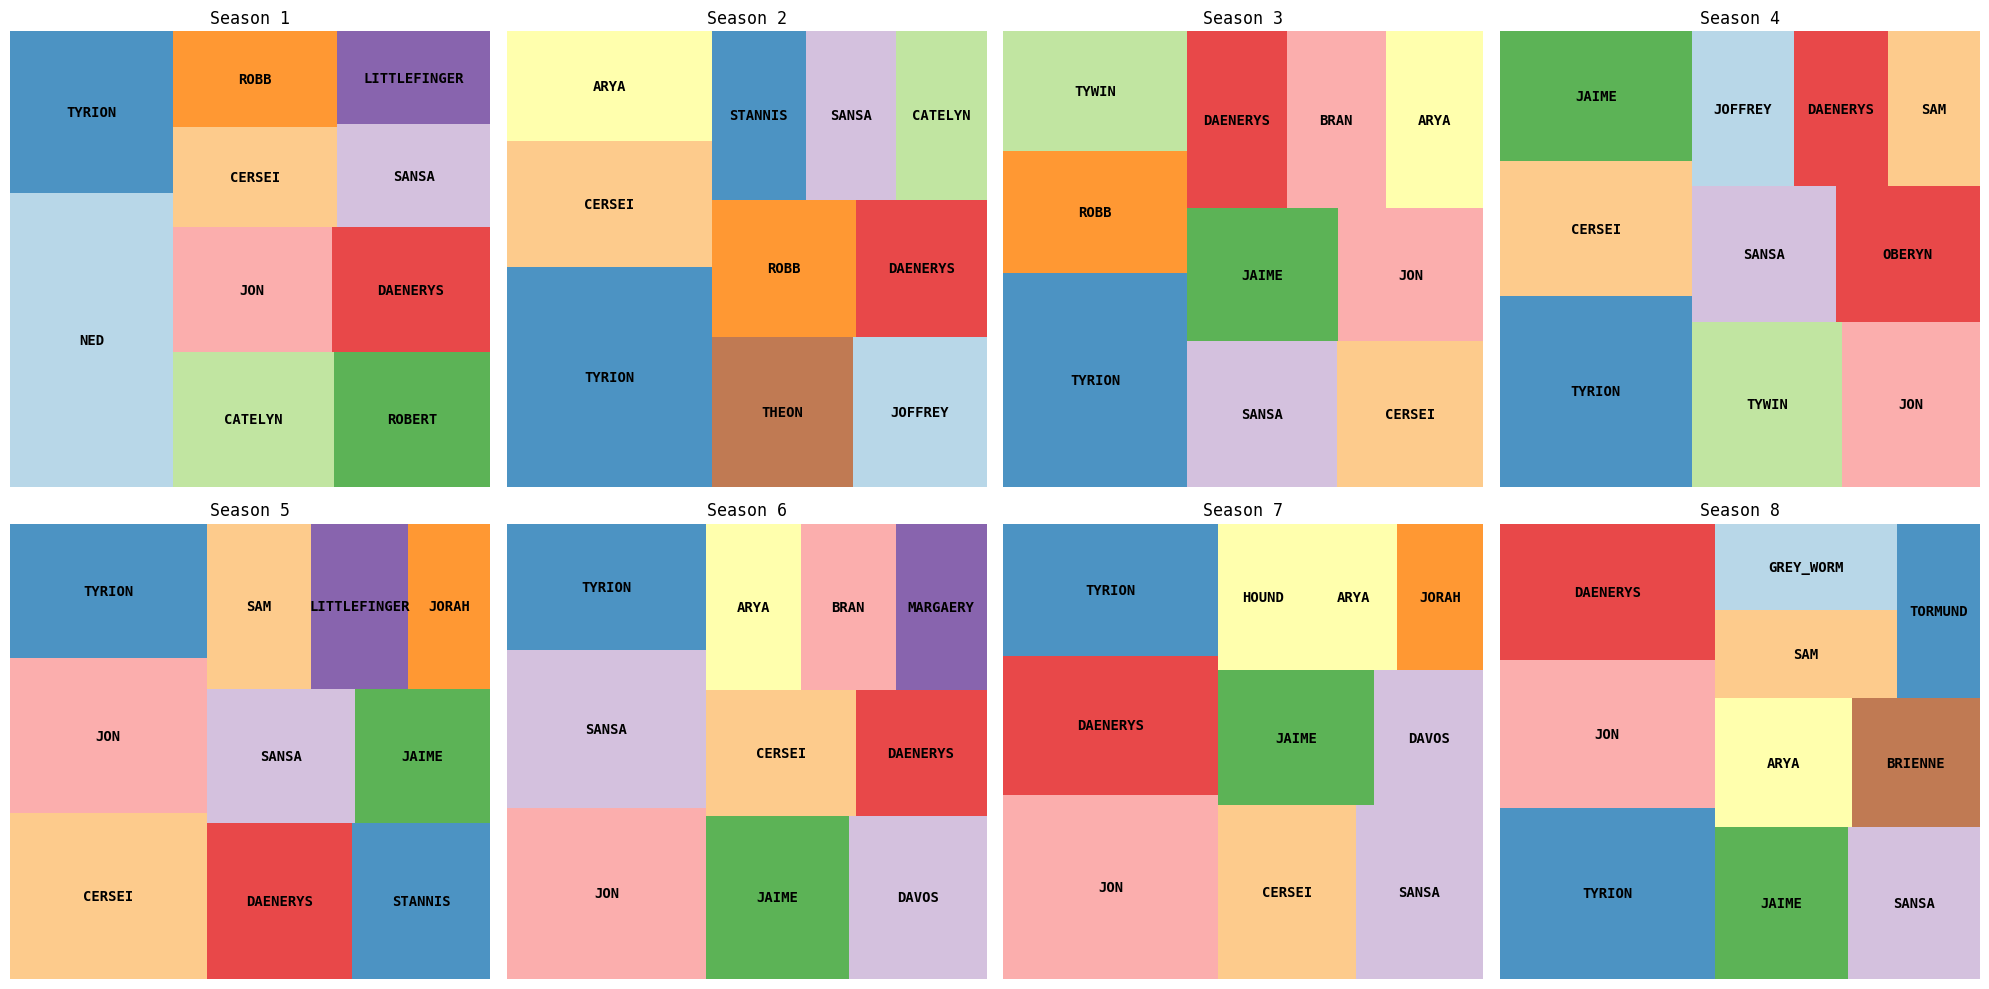

In [36]:
characters = all_seasons['Character'].unique()

palette = sns.color_palette("Paired", len(characters))
color_map = dict(zip(characters, palette))
seasons = all_seasons['Season'].unique()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, (season, ax) in enumerate(zip(seasons, axes)):
    df_season = all_seasons[all_seasons['Season'] == season]
    df_sorted = df_season.sort_values(by='Centrality Mean', ascending=False)
    colors = [color_map[char] for char in df_sorted['Character']]
    squarify.plot(sizes=df_sorted['Centrality Mean'], label=df_sorted['Character'], 
                  color=colors, alpha=0.8, ax=ax, 
                  text_kwargs={'color': 'black', 'fontsize': 10, 'weight': 'bold'})
    ax.set_title(season)
    ax.axis('off')
plt.tight_layout()
plt.show()

Many of the important personalities do not appear in all 8 seasons. We loose Ned at the end of the first season. Robb and Catelyn make their last appearances at the end of the third season during the red wedding. 

The following characters accompany us throughout the series:
- Jon Snow 
- Sansa Stark
- Arya Stark
- Tyrion Lannister
- Cersei Lannister
- Jaime Lannister 
- Daenerys Targaryen 
- Theon Greyjoy 
- Sandor Clegane (The Hound)
- Varys
- Bran Stark
- Samwell Tarly
- Brienne of Tarth (Introduced in Season 2 but survives until the end)

Let´s check the relevance of those characters through out the series. 

In [37]:
# Filter characters of interest
characters_of_interest = ['TYRION', 'SANSA', 'ARYA', 'CERSEI', 'JAIME', 'DAENERYS', 'THEON', 'VARYS', 'BRAN', 'SAM', 'BRIENNE', 'HOUND']
df_filtered = all_seasons[all_seasons['Character'].isin(characters_of_interest)]

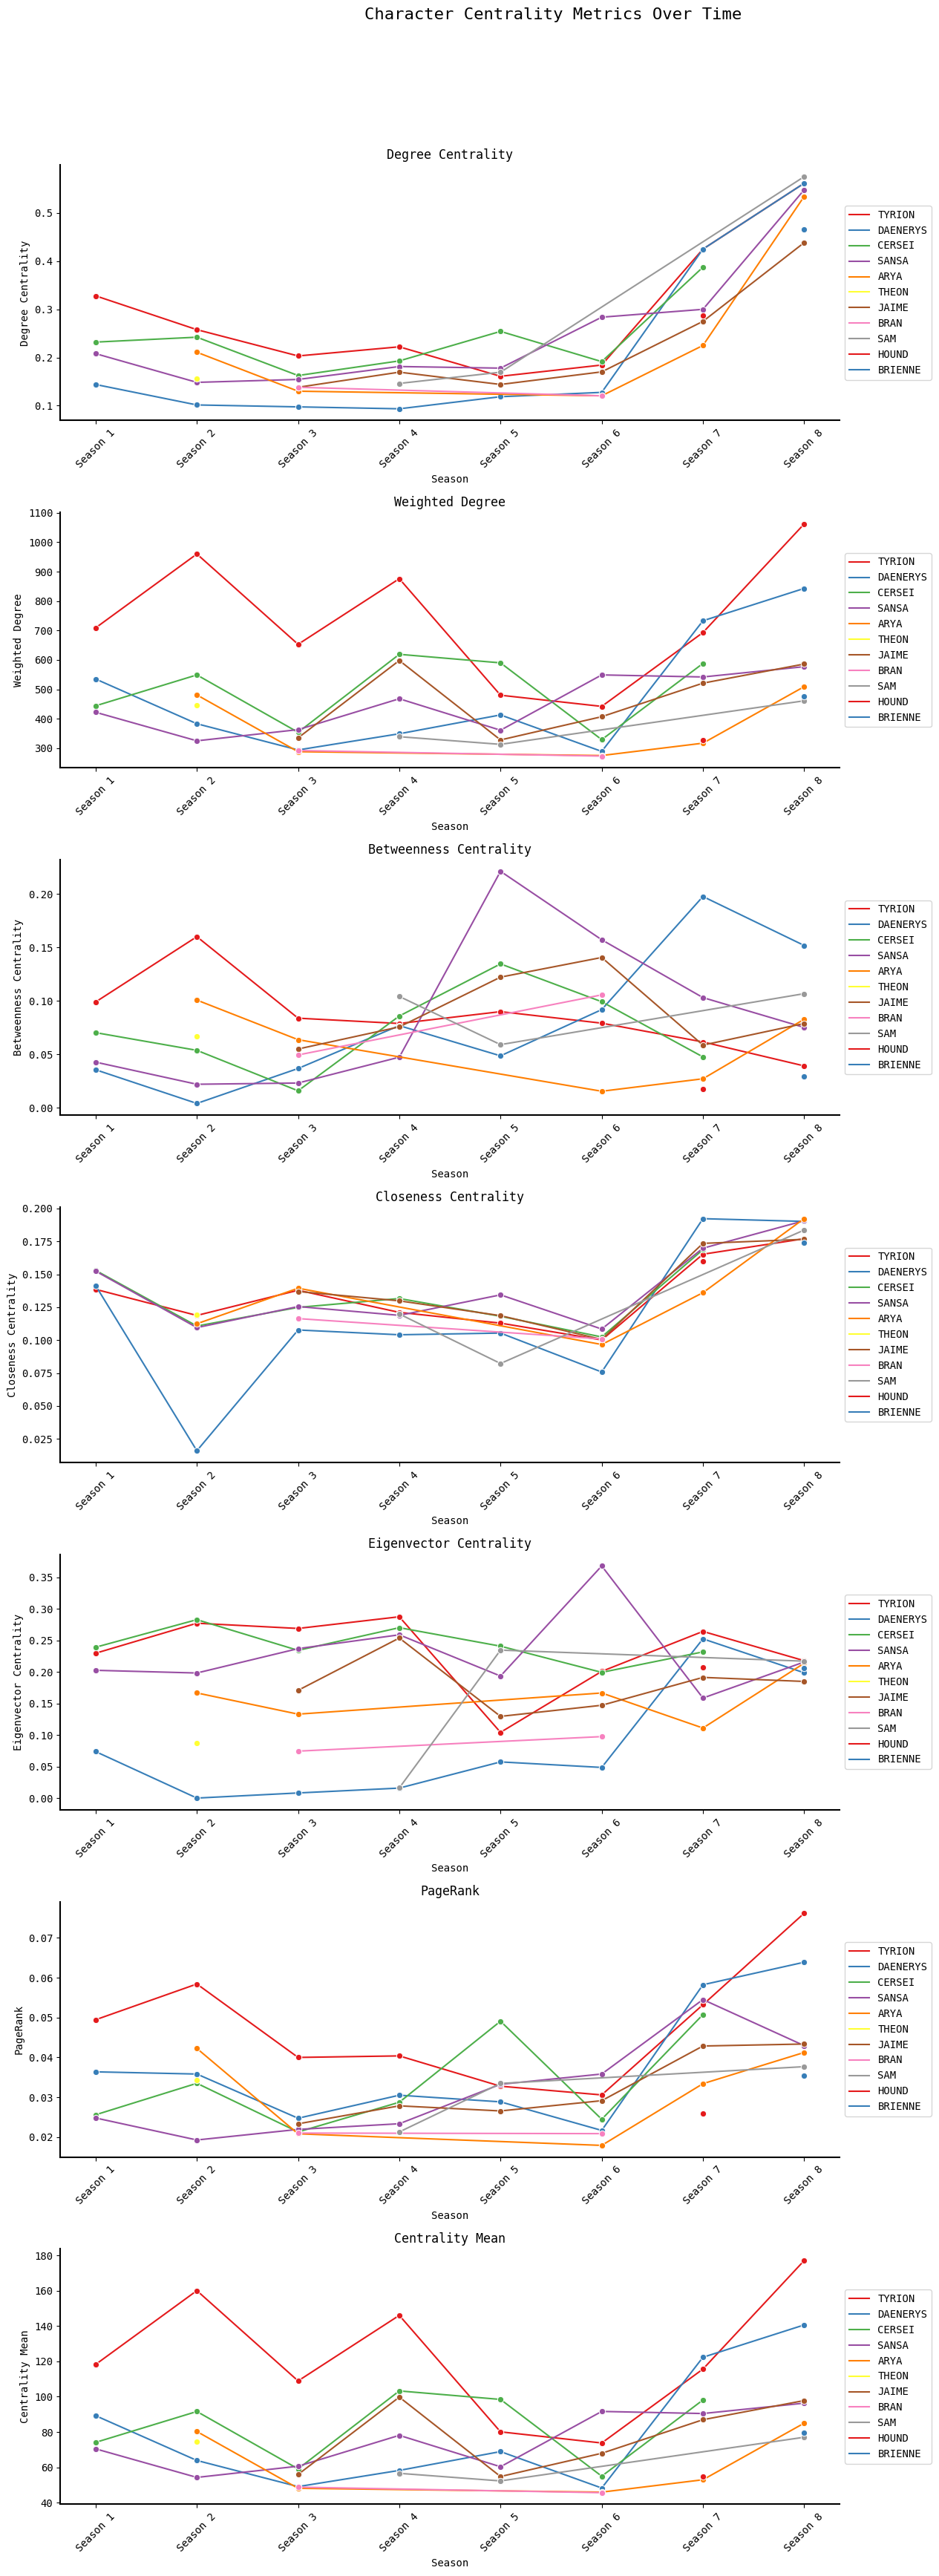

In [38]:
metrics = ['Degree Centrality', 'Weighted Degree', 'Betweenness Centrality', 'Closeness Centrality', 'Eigenvector Centrality', 'PageRank', 'Centrality Mean']
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(15, 5 * len(metrics)), sharex=False, sharey=False)
fig.suptitle('Character Centrality Metrics Over Time', fontsize=16, y=0.99)
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(data=df_filtered, x='Season', y=metric, hue='Character', marker='o', ax=ax, palette='Set1')
    ax.set_title(metric)
    ax.set_xlabel('Season')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 0.95])
plt.show()

The plots about the diffent centrality scores for each character over time provides a detailed view of how each character´s influence and importance within the network evolved throughout the series. 

Tyrion Lannister emerges as a consistently central figure, exhibiting high scores across all centrality measures. His Degree Centrality is particularly notable, reflecting the large number of direct interactions he has with other characters. This is complemented by his consistently high Betweenness Centrality, which shows that he often acts as a bridge between different groups or individuals, helping to facilitate the flow of information. His high Eigenvector Centrality indicates that his connections are not just numerous but also connected to other key players, underscoring his deep integration into the show's power dynamics. Over the seasons, Tyrion's influence remains remarkably high, as seen in his PageRank scores, which suggest his enduring centrality in the character network.

Similarly, Daenerys Targaryen shows a clear trajectory of rising centrality over time, particularly in the later seasons, where she becomes a more dominant figure. Her Closeness Centrality improves steadily, indicating her increasing proximity to other key characters, both geographically and politically, as she consolidates power. Her Eigenvector Centrality also rises, especially in later seasons, reflecting her connections with other influential figures such as Tyrion and Jon Snow. The steady increase in her Betweenness Centrality suggests that as she gains power, she becomes a pivotal connector in the network, acting as a bridge between different factions.

Sansa Stark also shows a fascinating evolution. While initially having lower centrality scores, her influence rises significantly in later seasons, particularly in Betweenness Centrality, where she becomes a more critical player in connecting others. This suggests that Sansa's role as a political influencer grows as she becomes more strategic and connected with powerful figures. Her increasing Eigenvector Centrality mirrors this rise in influence, showing that she is not only becoming more connected but also more integrated into the core of the power network.

Other characters, like Cersei Lannister and Jaime Lannister, show more steady yet notable centrality patterns. Cersei remains influential throughout, with consistently strong scores across measures like Closeness Centrality and PageRank, reflecting her persistent role in the core of the network. Jaime, while initially less central, sees an increase in centrality over time, particularly in later seasons, suggesting his growing importance as he becomes more involved in key events and relationships.

# Final Words

In this notebook, we went through the world of Westeros and Essos by applying social network analysis to the intricate web of relationships in Game of Thrones. By examining each season individually, we uncovered the key characters who wielded the most influence and explored how their importance shifted over time. The network graphs illustrated how alliances formed and dissolved, revealing the ebb and flow of power as the story unfolded. Through centrality metrics such as degree, betweenness, closeness, and PageRank, we were able to quantify each character's influence and role within the complex narrative. Our analysis not only identified the dominant figures in each season but also highlighted the evolving dynamics of power across the series, showing how characters like Tyrion, Daenerys, and Sansa rose in prominence, while others maintained steady influence. Ultimately, this social network analysis provided a unique perspective on the series, shedding light on the underlying forces that drive the plot and character development. As we conclude, it is clear that "Game of Thrones" is more than just a tale of battles and politics—it is a story defined by relationships, connections, and the subtle interplay of power, all of which are beautifully illuminated through the lens of social network analysis.

>**Thank you for reading this notebook to the end. If you liked it I would be very happy about an upvote. I am also very happy to receive feedback. 🙏**